In [1]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import fisher_exact
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import Image
import plotly.express as px
from outliers import smirnov_grubbs as grubbs
from scipy.stats import ttest_ind
import statsmodels.stats.power as smp
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


df_fifa = pd.read_csv("~/R/Prac/Fifa23_Players.csv")
df_fifa.head()

Name  Ratings    Position           Version    PS  SKI  WF  \
0             Pelé       98         CAM   Icon  Explosive     0    5   4   
1          Ronaldo       96          ST  Icon  Controlled     0    5   5   
2  Zinedine Zidane       96         CAM  Icon  Controlled     0    5   5   
3             Pelé       95  CF  CAM,ST   Icon  Explosive  4.2M    5   4   
4    Ferenc Puskás       94          CF  Icon  Controlled     0    4   3   

      WR  PAC  SHO  ...  DRI  DEF  PHY                          Body  \
0  H \ M   95   96  ...   96   60   76   173cm | 5'8"  Unique (70kg)   
1  M \ M   97   95  ...   95   45   76       183cm | 6'0"  R9 (78kg)   
2  M \ M   85   92  ...   95   75   86  185cm | 6'1"  Average (77kg)   
3  H \ M   96   93  ...   95   56   75   173cm | 5'8"  Unique (69kg)   
4  H \ M   91   96  ...   92   46   76   172cm | 5'8"  Stocky (72kg)   

  Popularity   BS   IGS          Club League  Country  
0       1790  516  2513  FUT 22 ICONS  Icons   Brazil  
1       2765  489  2341  FUT 22 ICONS  Icons   Brazil  
2       1031  529  2548  FUT 22 ICONS  Icons   France  
3       1277  505  2452  FUT 22 ICONS  Icons   Brazil  
4       1710  492  2396  FUT 22 ICONS  Icons  Hungary  

[5 rows x 21 columns]

Данные с kaggle: FIFA 23 Fut Players Dataset
https://www.kaggle.com/datasets/bryanb/fifa-player-stats-database?select=FIFA21_official_data.csv
Данные содержат информацию о каждом игроке в игре FIFA 23, такую как: Ratings - общий рейтинг, 
PAC - скорость, SHO - удары, PAS - пасы, DRI - дриблинг, DEF - защита, PHY - сила, мощь.
В своей работе я использовал в основном последние 6 признаков, т.к. их не нужно заниматься масштабированием, они все находятся в диапозоне от 1 до 100, я предполагаю, что именно они вносят основной вклад в рейтинг игрока.

In [2]:
df_fifa = df_fifa.dropna()

In [3]:
df_fifa["Height"] = df_fifa["Body"].apply(lambda s: int(re.findall(r"(\d{3})cm", str(s))[0]))
df_fifa["Weight"] = df_fifa["Body"].apply(lambda s: len(re.findall(r"\((\d{2,3})kg\)", str(s))))
df_fifa = df_fifa.drop(df_fifa[df_fifa["Weight"] == 0].index)
df_fifa["Weight"] = df_fifa["Body"].apply(lambda s: int(re.findall(r"\((\d{2,3})kg\)", str(s))[0]))
df_fifa.index = range(df_fifa.shape[0])

In [4]:
df_fifa.head()

Name  Ratings    Position           Version    PS  SKI  WF  \
0             Pelé       98         CAM   Icon  Explosive     0    5   4   
1          Ronaldo       96          ST  Icon  Controlled     0    5   5   
2  Zinedine Zidane       96         CAM  Icon  Controlled     0    5   5   
3             Pelé       95  CF  CAM,ST   Icon  Explosive  4.2M    5   4   
4    Ferenc Puskás       94          CF  Icon  Controlled     0    4   3   

      WR  PAC  SHO  ...  PHY                          Body  Popularity   BS  \
0  H \ M   95   96  ...   76   173cm | 5'8"  Unique (70kg)        1790  516   
1  M \ M   97   95  ...   76       183cm | 6'0"  R9 (78kg)        2765  489   
2  M \ M   85   92  ...   86  185cm | 6'1"  Average (77kg)        1031  529   
3  H \ M   96   93  ...   75   173cm | 5'8"  Unique (69kg)        1277  505   
4  H \ M   91   96  ...   76   172cm | 5'8"  Stocky (72kg)        1710  492   

    IGS          Club  League  Country Height Weight  
0  2513  FUT 22 ICONS   Icons   Brazil    173     70  
1  2341  FUT 22 ICONS   Icons   Brazil    183     78  
2  2548  FUT 22 ICONS   Icons   France    185     77  
3  2452  FUT 22 ICONS   Icons   Brazil    173     69  
4  2396  FUT 22 ICONS   Icons  Hungary    172     72  

[5 rows x 23 columns]

In [5]:
df_fifa = df_fifa[['Name', 'Ratings', 'PAC', 'SHO', 'PAS', 'DRI', 'DEF', 'PHY', 'Country', 'Height', 'Weight']]

In [6]:
df_fifa.head()

Name  Ratings  PAC  SHO  PAS  DRI  DEF  PHY  Country  Height  \
0             Pelé       98   95   96   93   96   60   76   Brazil     173   
1          Ronaldo       96   97   95   81   95   45   76   Brazil     183   
2  Zinedine Zidane       96   85   92   96   95   75   86   France     185   
3             Pelé       95   96   93   90   95   56   75   Brazil     173   
4    Ferenc Puskás       94   91   96   91   92   46   76  Hungary     172   

   Weight  
0      70  
1      78  
2      77  
3      69  
4      72

In [7]:
df_fifa.to_csv("fifa23.csv")

# Задание 1

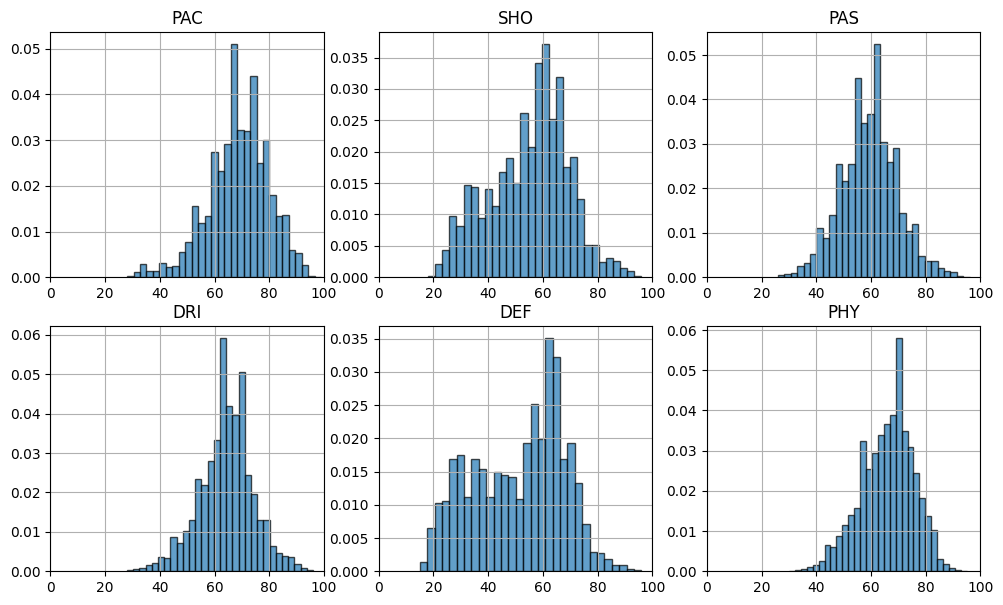

In [8]:
quality_card = ['PAC', 'SHO', 'PAS', 'DRI', 'DEF', 'PHY']

plt.figure(figsize=(12, 7))

for i in range(1, 7):
    
    plt.subplot(2, 3, i)
    plt.title(quality_card[i - 1])
    plt.hist(df_fifa[[quality_card[i - 1]]],  bins=30, edgecolor='black', alpha=0.7, density=True)
    plt.xlim(0, 100)
    plt.grid(True) 
    
plt.show()

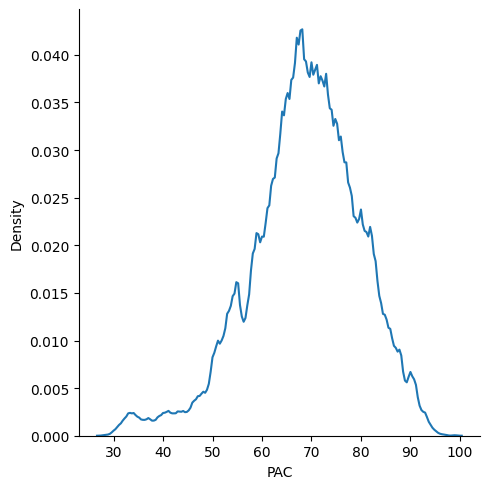

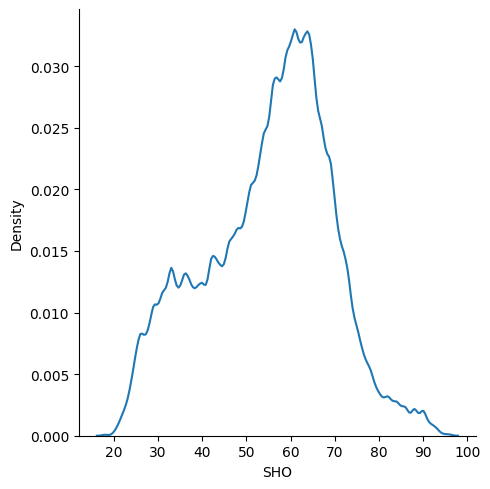

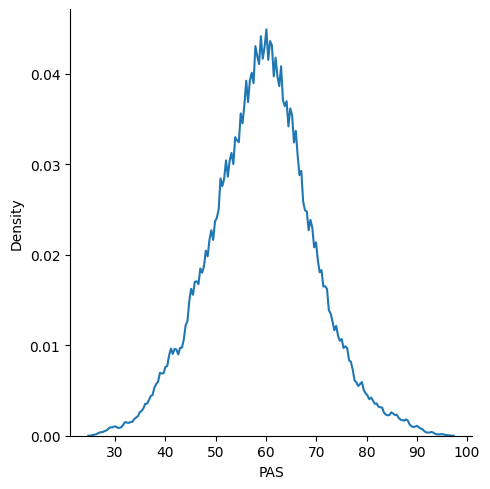

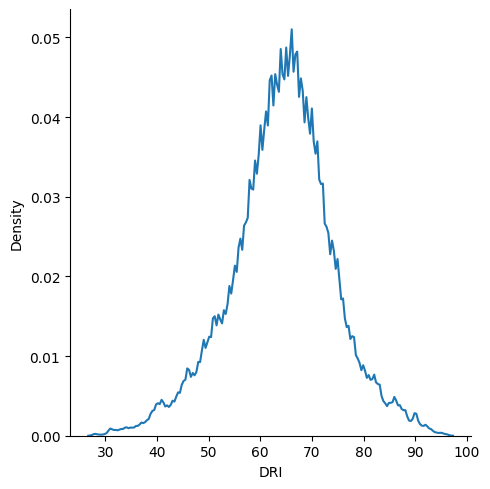

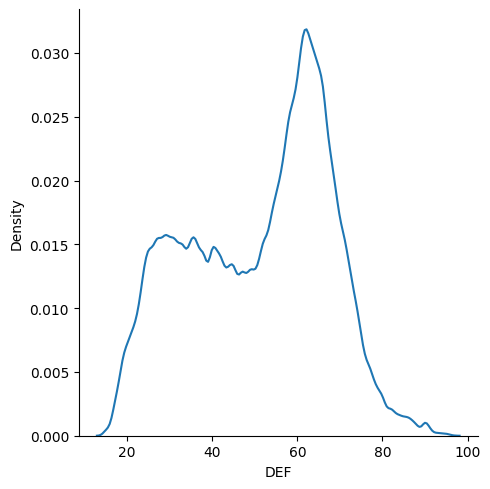

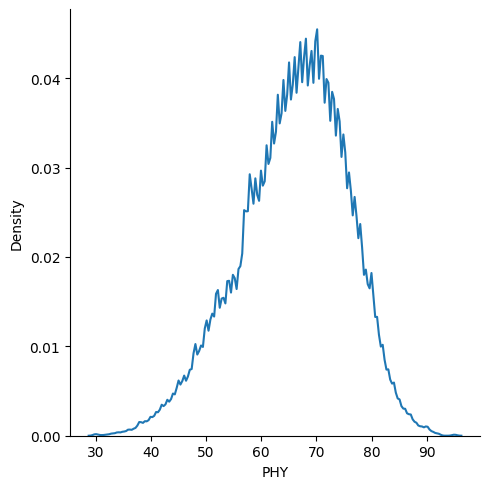

In [9]:
for i, j in zip(quality_card, range(1, len(quality_card) + 1)):
    sns.displot(df_fifa, x=i,  kind="kde", bw_adjust=0.3)

<AxesSubplot: xlabel='Ratings', ylabel='Density'>

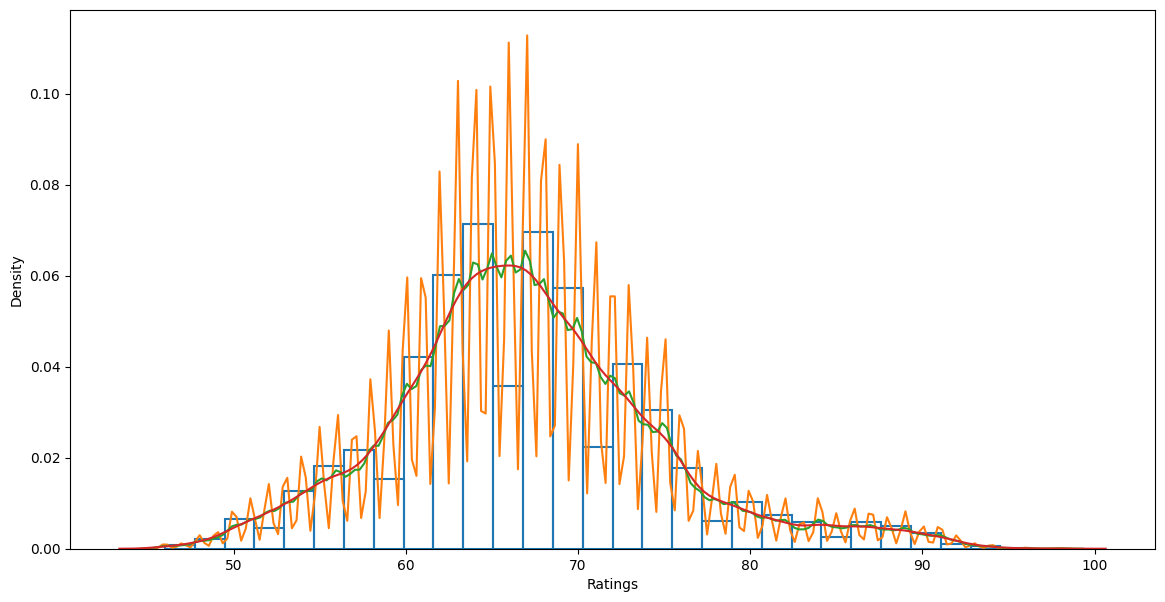

In [10]:
f, ax = plt.subplots(figsize=(14, 7))
sns.histplot(x='Ratings',
             stat="density",
             bins=30,
             fill=False,
             data=df_fifa);

sns.kdeplot(x='Ratings',
            bw_adjust=0.2,
            label='bw: 0.2',
            data=df_fifa)

sns.kdeplot(x='Ratings',
            bw_adjust=0.4,
            label='bw: 0.4',
            data=df_fifa)

sns.kdeplot(x='Ratings',
            bw_adjust=0.8,
            label='bw: 0.8',
            data=df_fifa)

### R:

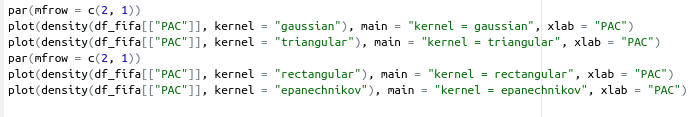

In [11]:
Image("./Screan_R/Task1_code.png")

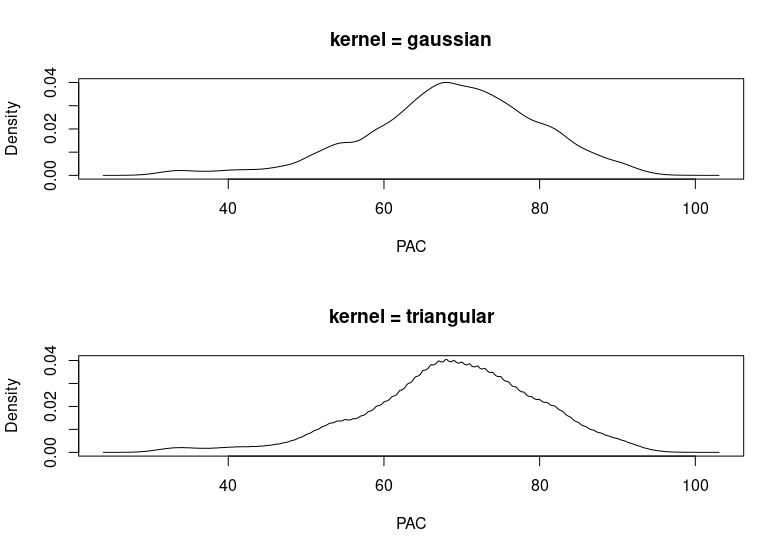

In [12]:
Image("./Screan_R/Task1.png")

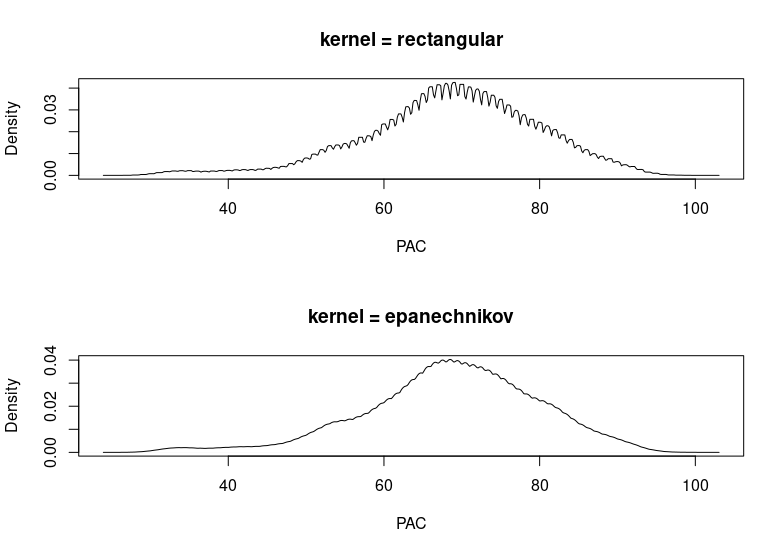

In [13]:
Image("./Screan_R/Task1_1.png")

# Задание 2

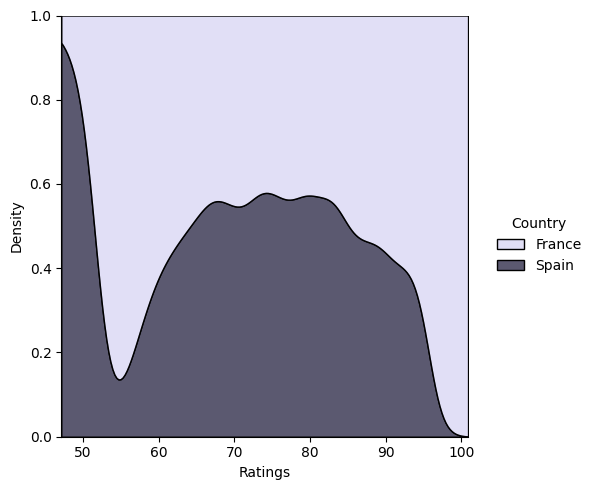

In [14]:
sns.displot(data=df_fifa.loc[df_fifa["Country"].isin(["Spain", "France"])], x='Ratings', 
            hue = 'Country', 
            multiple="fill", kind="kde", palette="ch:rot=-0,light=.85")

<AxesSubplot: xlabel='Country', ylabel='Ratings'>

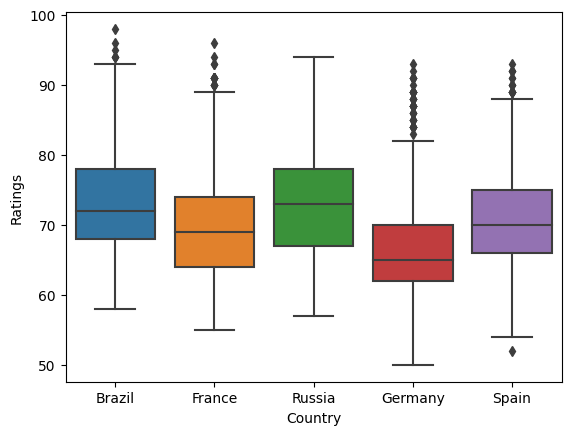

In [15]:
subCountry = ["France", "Spain", "Germany", "Brazil", "Russia"]
df = df_fifa.loc[df_fifa["Country"].isin(subCountry)]
sns.boxplot(data = df, y = "Ratings", x = "Country")

<AxesSubplot: xlabel='Ratings', ylabel='Country'>

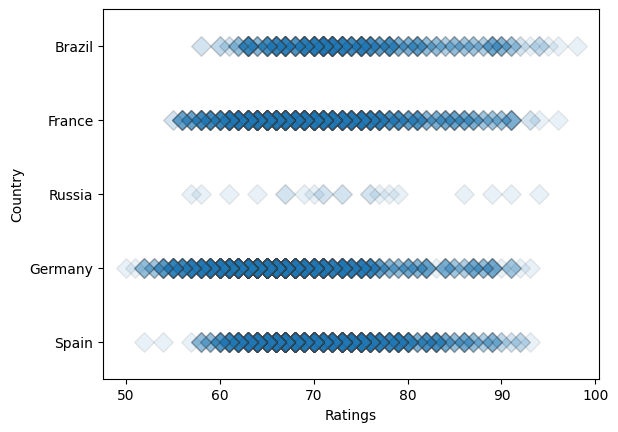

In [16]:
sns.stripplot(
    data = df_fifa.loc[df_fifa["Country"].isin(subCountry)], 
    y = "Country", x = "Ratings",
    jitter=False, s=10, marker="D", linewidth=1, alpha=.1,
)

In [17]:
df2 = df_fifa.groupby("Country")[["Ratings"]].max()
df2 = df2.reset_index().sort_values(by='Ratings', ascending=False).iloc[:30]
df2.sort_values(by='Ratings', ascending=True, inplace=True)
df2.head()

Country  Ratings
58                 Ghana       90
52               Finland       90
136               Sweden       90
34               Croatia       90
118  Republic of Ireland       90

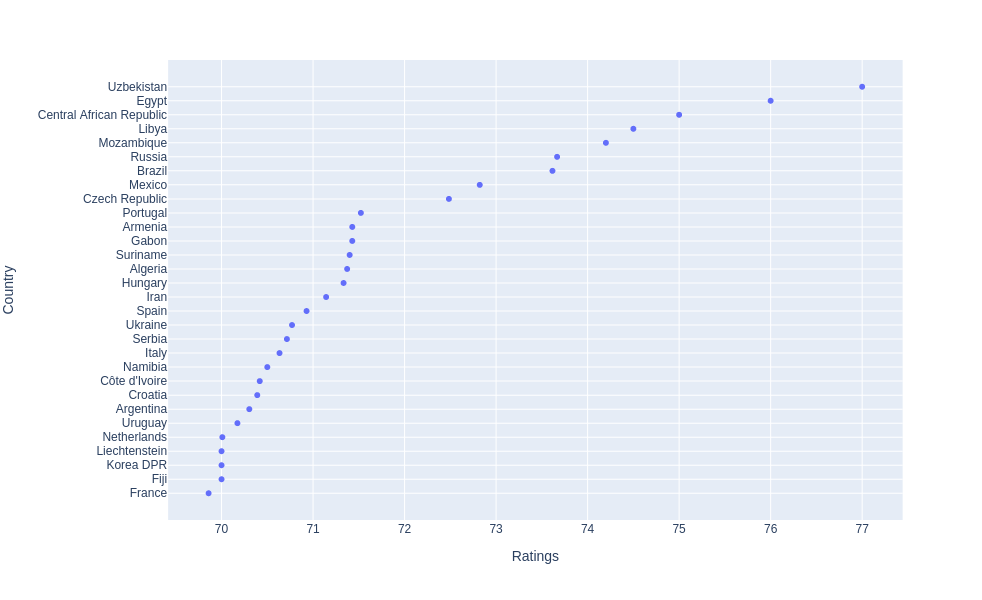

In [18]:
#fig = px.scatter(df2, y ="Country", x = "Ratings", height=600)
#fig.show()
Image("./Screan_R/Task2_sc_1.png")

In [19]:
df2 = df_fifa.groupby("Country")[["Ratings"]].mean()
df2 = df2.reset_index().sort_values(by='Ratings', ascending=False).iloc[:30]
df2.sort_values(by='Ratings', ascending=True, inplace=True)
df2.head()

Country    Ratings
53          France  69.858609
51            Fiji  70.000000
82       Korea DPR  70.000000
89   Liechtenstein  70.000000
105    Netherlands  70.008811

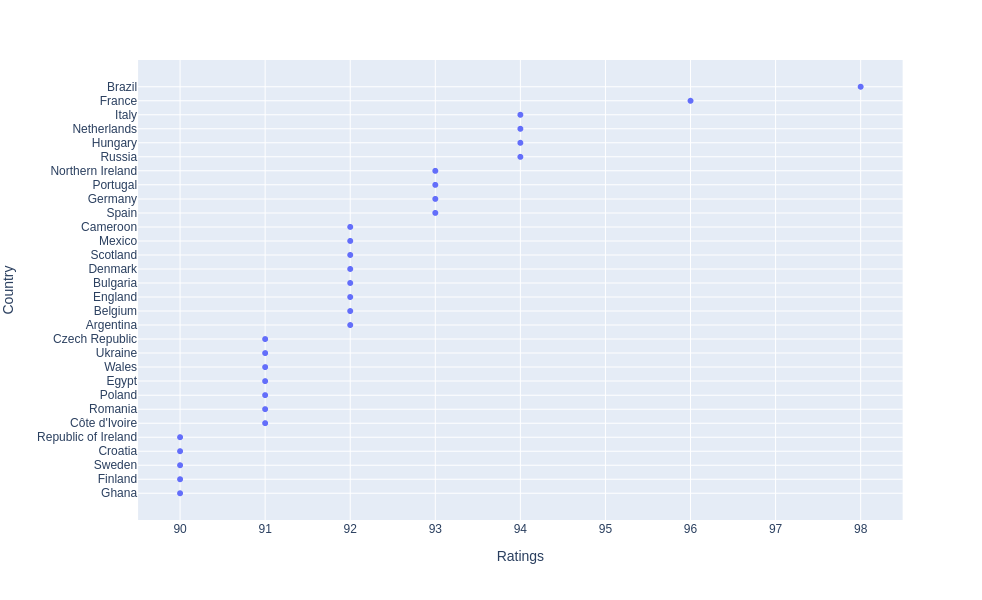

In [20]:
#fig = px.scatter(df2, y ="Country", x = "Ratings", height=600)
#fig.show()
Image("./Screan_R/Task2_sc_2.png")

###  R:

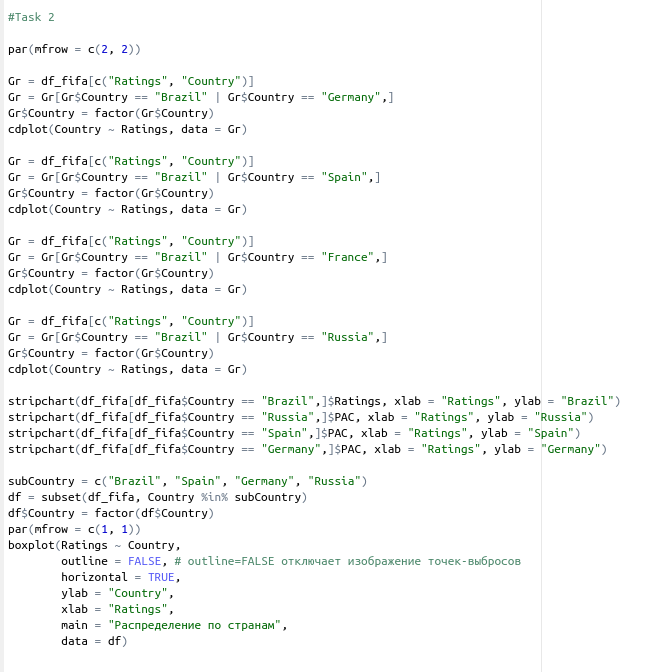

In [21]:
Image("./Screan_R/Task2_R_code.png")

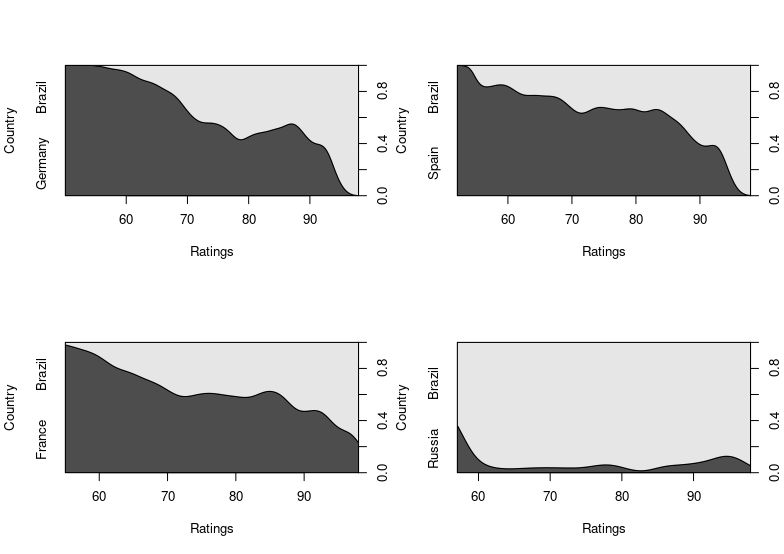

In [22]:
Image("./Screan_R/Task2_R_1.png")

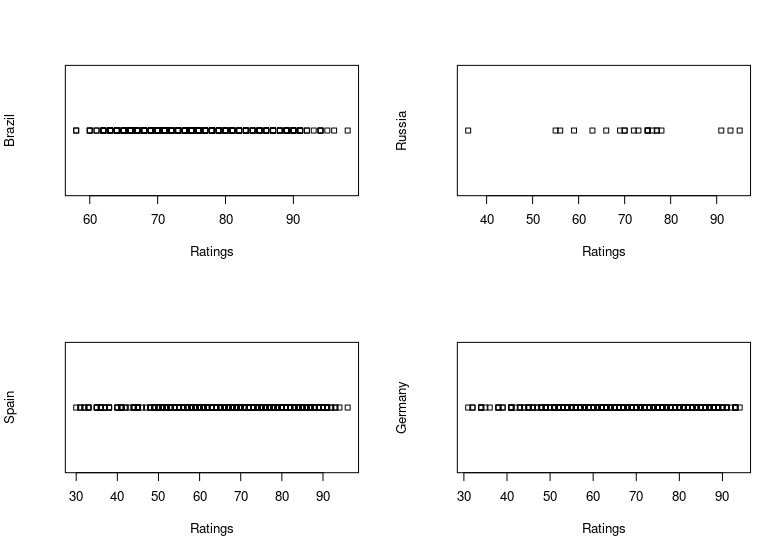

In [23]:
Image("./Screan_R/Task2_R_2.png")

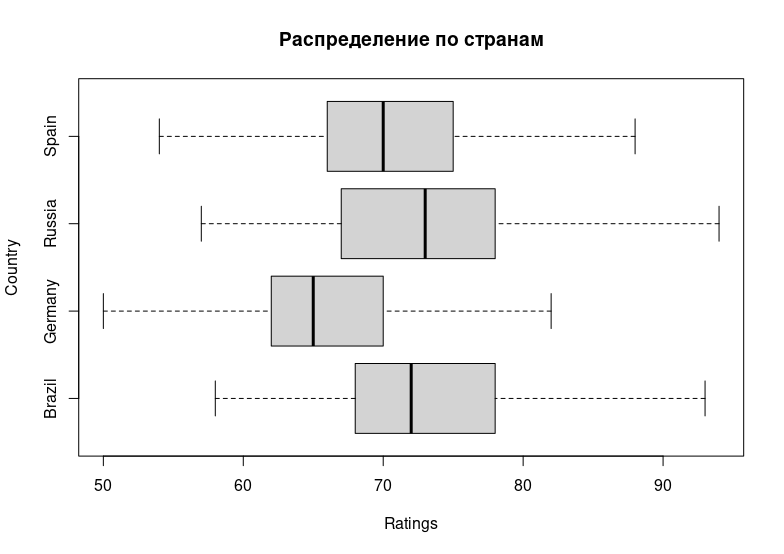

In [24]:
Image("./Screan_R/Task2_R_3.png")

# Задание 3

In [25]:
#Критерий Граббса
print(len(grubbs.test(df_fifa["Ratings"], alpha=.05)) != len(df_fifa["Ratings"]))
for i in quality_card:
    print(len(grubbs.test(df_fifa[i], alpha=.05)) != len(df_fifa[i]))

False
False
False
False
False
False
False


In [26]:
# =>  выбросов нет, добавим выброс:
arr = np.append(df_fifa["Ratings"].values, 102)
grubbs.max_test_indices(arr, alpha = 0.05)

[16443]

3.9919350537809524

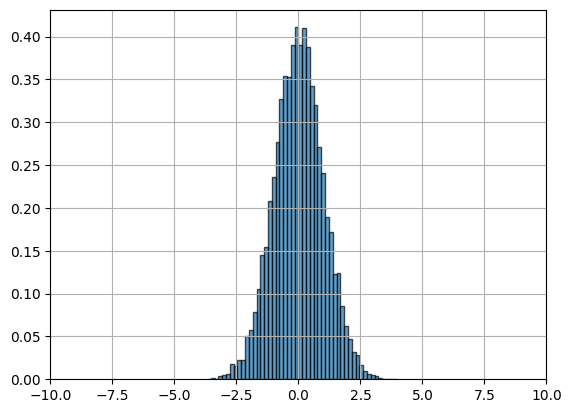

In [27]:
x = np.random.randn(10000)
plt.hist(x,  bins=50, edgecolor='black', alpha=0.7, density=True)
plt.xlim(-10, 10)
plt.grid(True) 

grubbs.test(np.append(x, 500), alpha=.05).max() #выброс удалился

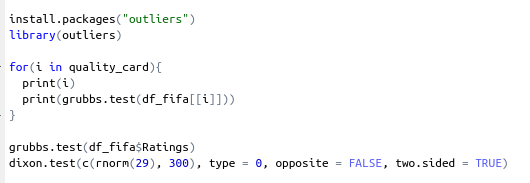

In [28]:
Image("./Screan_R/Task3_code.png")

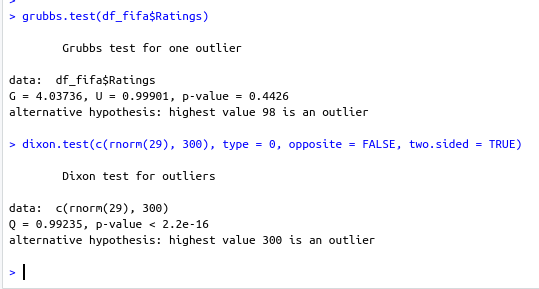

In [29]:
Image("./Screan_R/Task3_code_1.png")
# В первом случае H0 принимается при alpha = 0.05 (т.е. нет выбросов)
# Во втором случае H0 отвергается при alpha = 0.05 (искусственно добавленный выброс удалился)

# Задание 4

In [30]:
df = df_fifa[quality_card].copy()
df

PAC  SHO  PAS  DRI  DEF  PHY
0       95   96   93   96   60   76
1       97   95   81   95   45   76
2       85   92   96   95   75   86
3       96   93   90   95   56   75
4       91   96   91   92   46   76
...    ...  ...  ...  ...  ...  ...
16438   51   45   46   50   19   41
16439   54   37   46   46   43   51
16440   63   48   40   47   24   44
16441   55   25   29   34   48   57
16442   65   36   43   46   43   53

[16443 rows x 6 columns]

Добавим пропуски в данные: 

In [31]:
for i in range(50):
    column, index = (np.random.randint(0, 6), np.random.randint(0, df.shape[0]))
    df[quality_card[column]].iloc[index] = np.nan

/tmp/ipykernel_48894/143708791.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[quality_card[column]].iloc[index] = np.nan


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PAC     16433 non-null  float64
 1   SHO     16431 non-null  float64
 2   PAS     16433 non-null  float64
 3   DRI     16436 non-null  float64
 4   DEF     16436 non-null  float64
 5   PHY     16439 non-null  float64
dtypes: float64(6)
memory usage: 770.9 KB


In [33]:
df.to_csv('df_fifa_na.csv')

x = df[df.isnull().any(1)].index
df.iloc[x].head()

/tmp/ipykernel_48894/2334726195.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  x = df[df.isnull().any(1)].index


PAC   SHO   PAS   DRI   DEF   PHY
275    NaN  55.0  82.0  85.0  86.0  83.0
478    NaN  83.0  75.0  85.0  57.0  77.0
748   91.0  64.0  73.0  80.0   NaN  69.0
923   72.0   NaN  73.0  74.0  81.0  79.0
1898  67.0   NaN  71.0  74.0  75.0  78.0

In [34]:
df_arr_na = np.array(df)

Используя возможности "IterativeImputer" заполним пропуски средним значением 
и посчитаем MAE(Mean absolute error):

In [35]:
imp = IterativeImputer(initial_strategy="mean")
imp.fit(df_arr_na)
df_arr = imp.transform(df_arr_na)

In [36]:
arr = np.array(df_fifa[quality_card]) - df_arr
print(np.mean( abs(arr[arr > 0.000001]) ))

6.176725227228973


Аналогично заполним пропуски медианным значением:

In [37]:
imp = IterativeImputer(initial_strategy="median")
imp.fit(df_arr_na)
df_arr = imp.transform(df_arr_na)

In [38]:
arr = np.array(df_fifa[quality_card]) - df_arr
print(np.mean( abs(arr[arr > 0.000001]) ))

6.176725221288786


In [39]:
imp = IterativeImputer(initial_strategy="constant")
imp.fit(df_arr_na)
df_arr = imp.transform(df_arr_na)

In [40]:
arr = np.array(df_fifa[quality_card]) - df_arr
print(np.mean( abs(arr[arr > 0.000001]) ))

6.176724924574264


### R

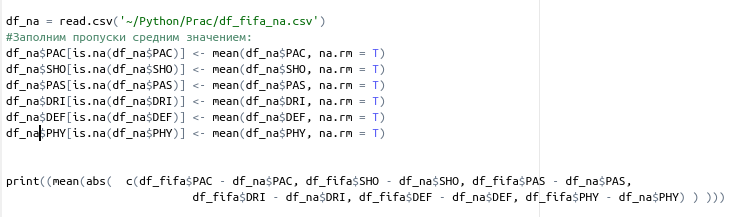

In [41]:
Image("./Screan_R/Task4.png")

MAE получился равным 8.065991

Вывод: В Python получились более приближенные значения, чем в R, но МАЕ даже в Python получилась немаленькой

# Задание 5

In [42]:
from scipy.stats import kstest, shapiro, anderson, cramervonmises, norm
from scipy import stats
from statsmodels.stats.diagnostic import lilliefors

Сгенерируем данные с нормальным распределением N(0, 1), N(10, 5) - для выборок
размера 50 и 3000

In [43]:
data_50_sd1 = norm.rvs(loc = 0, scale = 1, size = 50)
x_50_sd1 = np.linspace(-5, 5, 1000)
data_50_sd5 = norm.rvs(loc = 10, scale = 5, size = 50)
data_3000_sd1 = norm.rvs(loc = 0, scale = 1, size = 3000)
data_3000_sd5 = norm.rvs(loc = 10, scale = 5, size = 3000)
x_sd5 = np.linspace(-15, 35, 1000)
x_sd1 = np.linspace(-5, 5, 1000)

Произведем анализ с помощью графиоков эмпиричесикх функций:

<AxesSubplot: xlabel='x', ylabel='Proportion'>

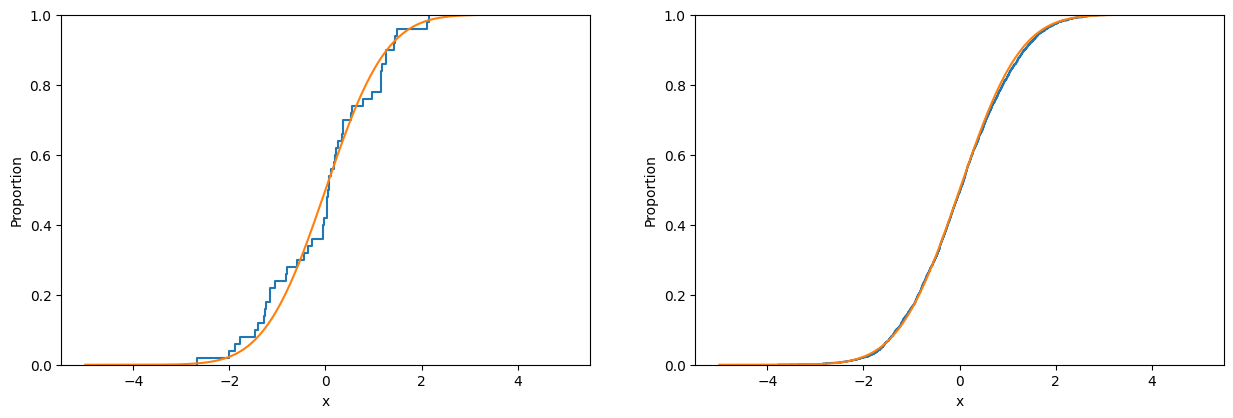

In [44]:
plt.figure(figsize = (15,10))
plt.subplot(2, 2, 1)
sns.ecdfplot(data_50_sd1)
df = pd.DataFrame({ "x" : x_sd1, "cdf" : norm.cdf(x_sd1)})
sns.lineplot(x="x", y="cdf", data=df)
plt.subplot(2, 2, 2)
sns.ecdfplot(data_3000_sd1)
sns.lineplot(x="x", y="cdf", data=df)

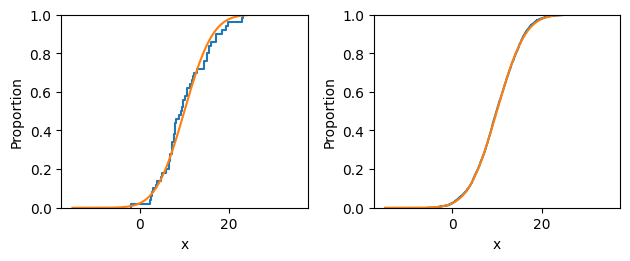

In [45]:
plt.subplot(2, 2, 3)
sns.ecdfplot(data_50_sd5)
df = pd.DataFrame({ "x" : x_sd5, "cdf" : norm.cdf(x_sd1)})
sns.lineplot(x="x", y="cdf", data=df)
plt.subplot(2, 2, 4)
sns.ecdfplot(data_3000_sd5)
sns.lineplot(x="x", y="cdf", data=df)
plt.tight_layout()

Произведем анализ с помощью графиоков квантилей:

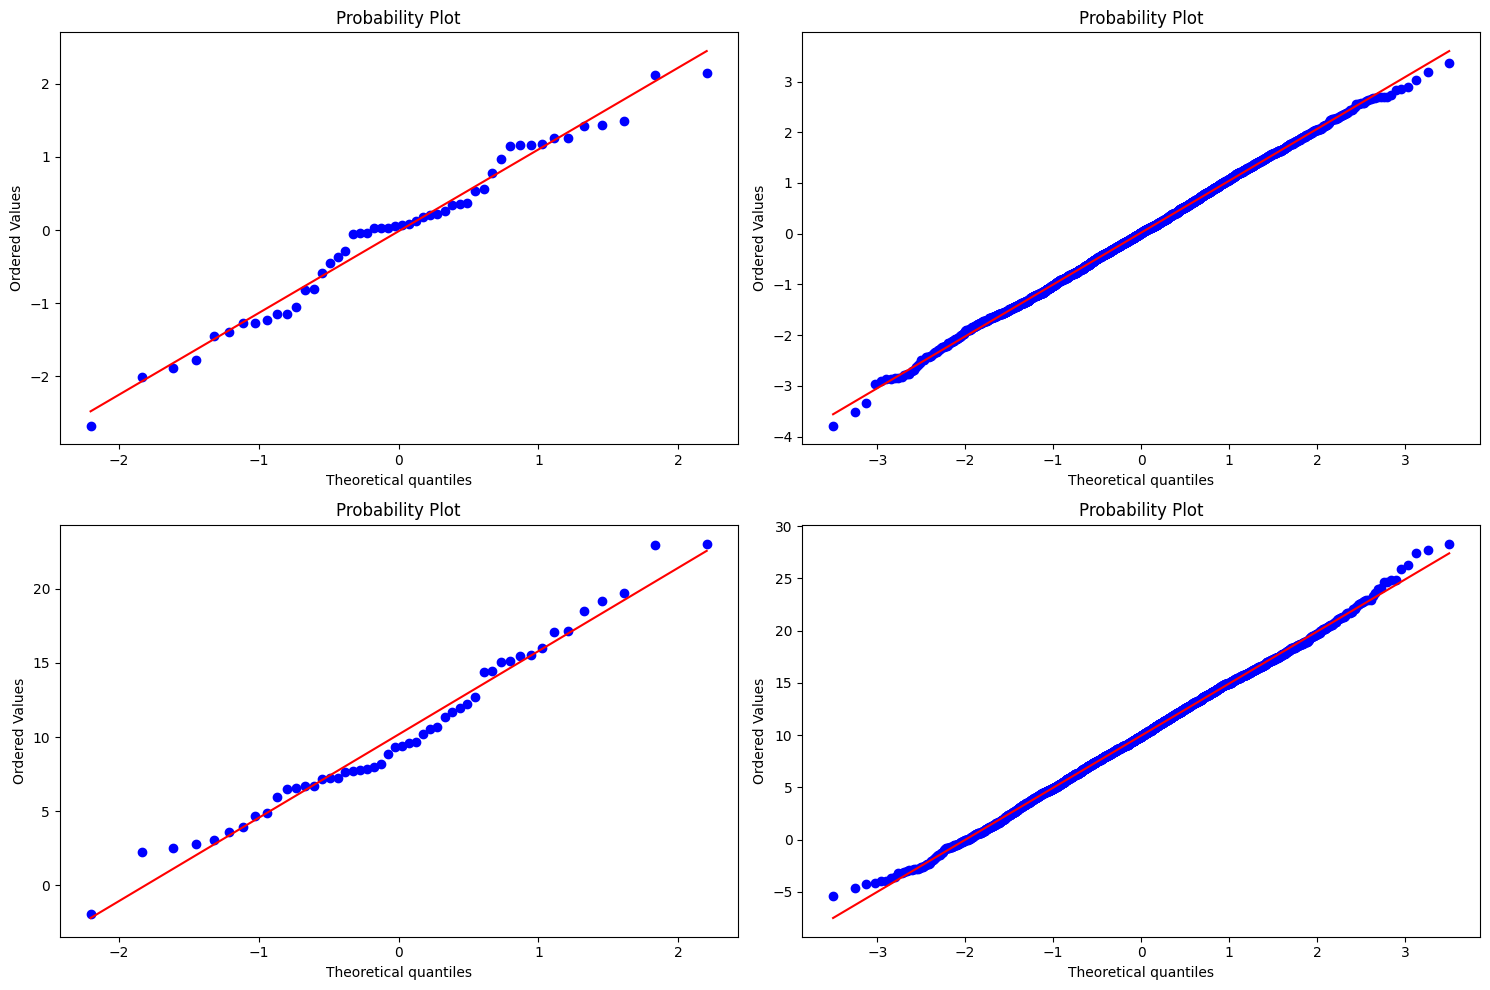

In [46]:
plt.figure(figsize = (15,10))
plt.subplot(2, 2, 1)
stats.probplot(data_50_sd1, dist="norm", plot=plt)
plt.subplot(2, 2, 2)

stats.probplot(data_3000_sd1, dist="norm", plot=plt)
plt.subplot(2, 2, 3)
stats.probplot(data_50_sd5, dist="norm", plot=plt)
plt.subplot(2, 2, 4)
stats.probplot(data_3000_sd5, dist="norm", plot=plt)
plt.tight_layout()

Применим необходимые тесты:

In [47]:
#Критерий Колмогорова-Смирнова
print("N(0, 1), n = 50:", kstest(data_50_sd1, stats.norm.cdf))
print("N(0, 1), n = 3000:", kstest(data_3000_sd1, stats.norm.cdf))
print("N(10, 5), n = 50:", kstest(data_3000_sd5, stats.norm.cdf))
print("N(10, 5), n = 3000:", kstest(data_3000_sd5, stats.norm.cdf))

N(0, 1), n = 50: KstestResult(statistic=0.11749609363492097, pvalue=0.4602115570371882)
N(0, 1), n = 3000: KstestResult(statistic=0.019269373215328733, pvalue=0.2125084322554871)
N(10, 5), n = 50: KstestResult(statistic=0.9255494186722233, pvalue=0.0)
N(10, 5), n = 3000: KstestResult(statistic=0.9255494186722233, pvalue=0.0)


In [48]:
#Критерий Шапиро-Уилка
print("N(0, 1), n = 50:", shapiro(data_50_sd1))
print("N(0, 1), n = 3000:", shapiro(data_3000_sd1))
print("N(10, 5), n = 50:", shapiro(data_3000_sd5))
print("N(10, 5), n = 3000:", shapiro(data_3000_sd5))

N(0, 1), n = 50: ShapiroResult(statistic=0.9779180288314819, pvalue=0.4678913950920105)
N(0, 1), n = 3000: ShapiroResult(statistic=0.9993335008621216, pvalue=0.36612361669540405)
N(10, 5), n = 50: ShapiroResult(statistic=0.9991932511329651, pvalue=0.20186592638492584)
N(10, 5), n = 3000: ShapiroResult(statistic=0.9991932511329651, pvalue=0.20186592638492584)


In [49]:
#Критерий Андерсона-Дарлинга
print("N(0, 1), n = 50:", anderson(data_50_sd1))
print("N(0, 1), n = 3000:", anderson(data_3000_sd1))
print("N(10, 5), n = 50:", anderson(data_3000_sd5))
print("N(10, 5), n = 3000:", anderson(data_3000_sd5))

N(0, 1), n = 50: AndersonResult(statistic=0.46030121876246, critical_values=array([0.538, 0.613, 0.736, 0.858, 1.021]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
N(0, 1), n = 3000: AndersonResult(statistic=0.4485439275867975, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
N(10, 5), n = 50: AndersonResult(statistic=0.39079371659227036, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
N(10, 5), n = 3000: AndersonResult(statistic=0.39079371659227036, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [50]:
#Критерий Крамера фон Мизеса
print("N(0, 1), n = 50:", cramervonmises(data_50_sd1, stats.norm.cdf))
print("N(0, 1), n = 3000:", cramervonmises(data_3000_sd1, stats.norm.cdf))
print("N(10, 5), n = 50:", cramervonmises(data_3000_sd5, stats.norm.cdf))
print("N(10, 5), n = 3000:", cramervonmises(data_3000_sd5, stats.norm.cdf))

N(0, 1), n = 50: CramerVonMisesResult(statistic=0.1033832315218461, pvalue=0.5703069882387644)
N(0, 1), n = 3000: CramerVonMisesResult(statistic=0.20742642626296331, pvalue=0.25354123266741657)
N(10, 5), n = 50: CramerVonMisesResult(statistic=902.2235466671141, pvalue=1.9789860816743499e-07)
N(10, 5), n = 3000: CramerVonMisesResult(statistic=902.2235466671141, pvalue=1.9789860816743499e-07)


In [51]:
#Критерий Колмогорова-Смирнова в модификации Лиллиефорса
print("N(0, 1), n = 50:", lilliefors(data_50_sd1))
print("N(0, 1), n = 3000:", lilliefors(data_3000_sd1))
print("N(10, 5), n = 50:", lilliefors(data_3000_sd5))
print("N(10, 5), n = 3000:", lilliefors(data_3000_sd5))

N(0, 1), n = 50: (0.12545704667769841, 0.04726876048401567)
N(0, 1), n = 3000: (0.010053144458779917, 0.6656563928460595)
N(10, 5), n = 50: (0.01046891086594981, 0.6019231919238351)
N(10, 5), n = 3000: (0.01046891086594981, 0.6019231919238351)


Вывод: Поскольку p-value для всех тестов больше критичсекого
значения в 0.05, то полученным значениям p-value принимаем гипотезу о нормальности
сгенерированных данных.

### R

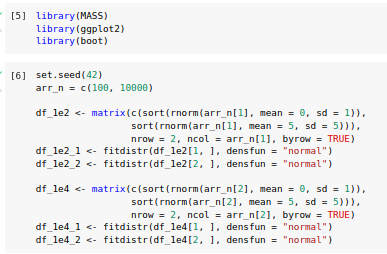

In [52]:
Image("./Screan_R/Task5_2.png")

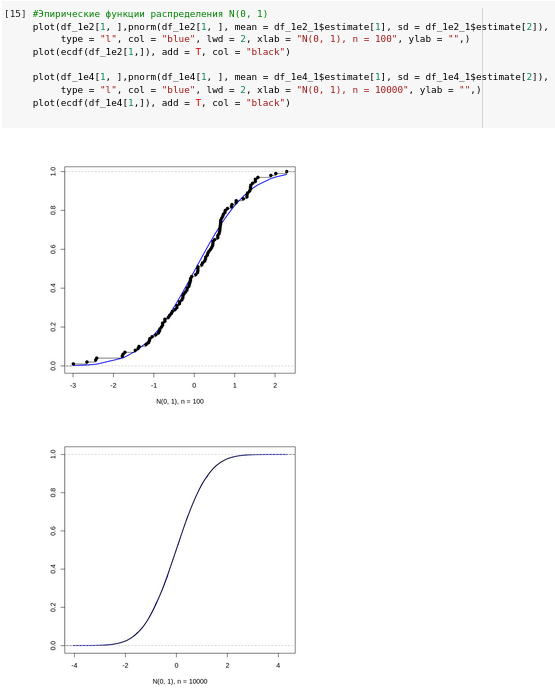

In [53]:
Image("./Screan_R/Task5_1.png")

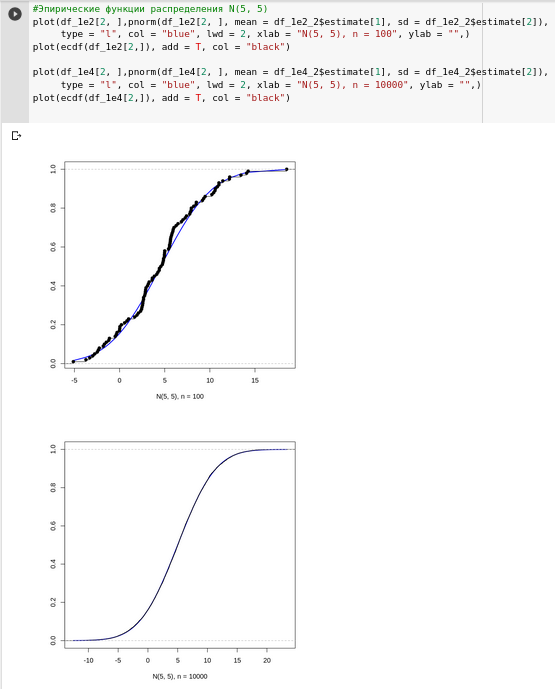

In [54]:
Image("./Screan_R/Task5_3.png")

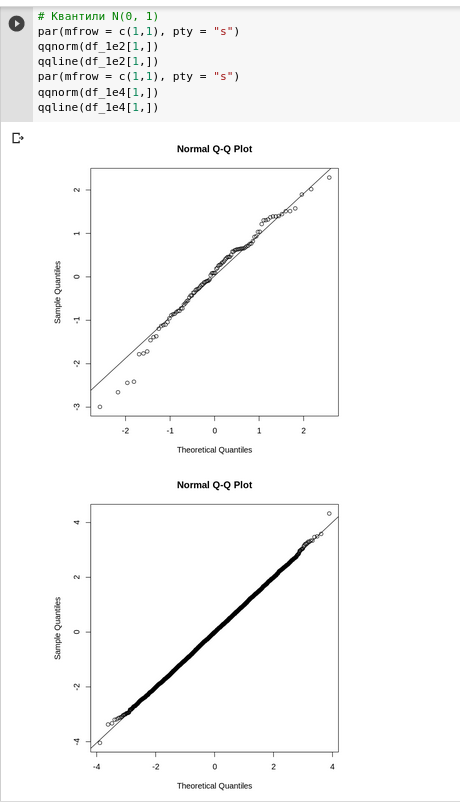

In [55]:
Image("./Screan_R/Task5_4.png")

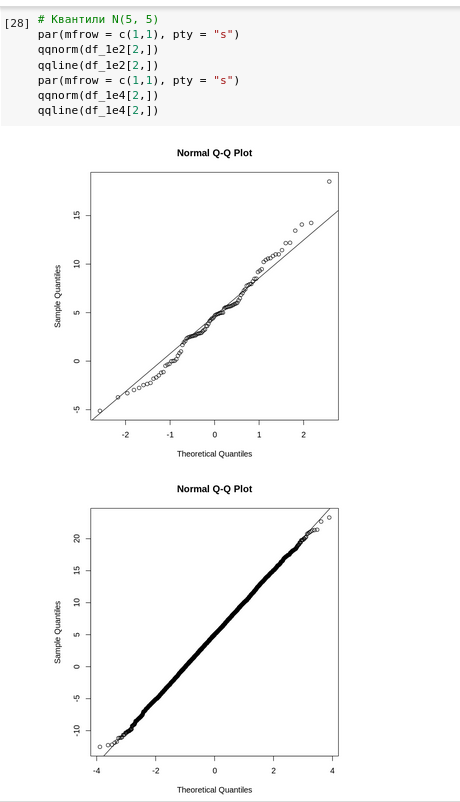

In [56]:
Image("./Screan_R/Task5_5.png")

Выполним для сгенерированных данных требуемые тесты:

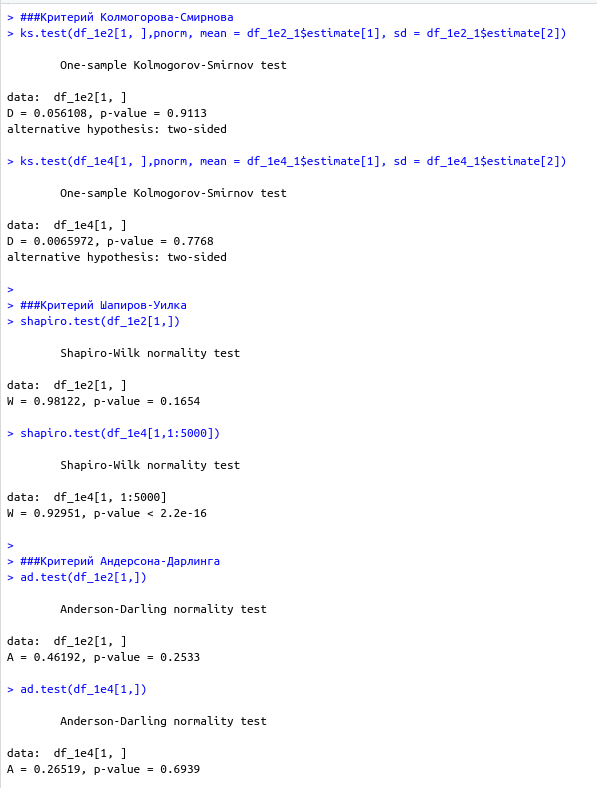

In [57]:
# N(0,1)
Image("./Screan_R/Task5_7.png")

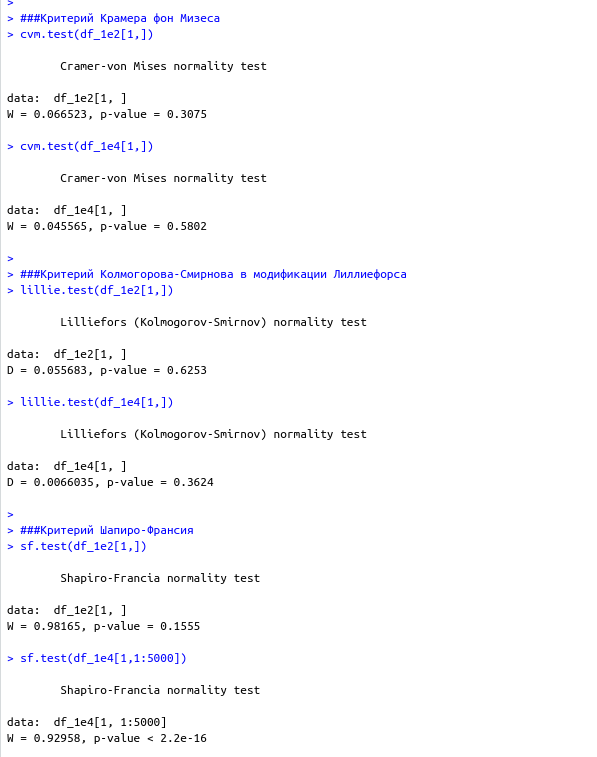

In [58]:
Image("./Screan_R/Task5_8.png")

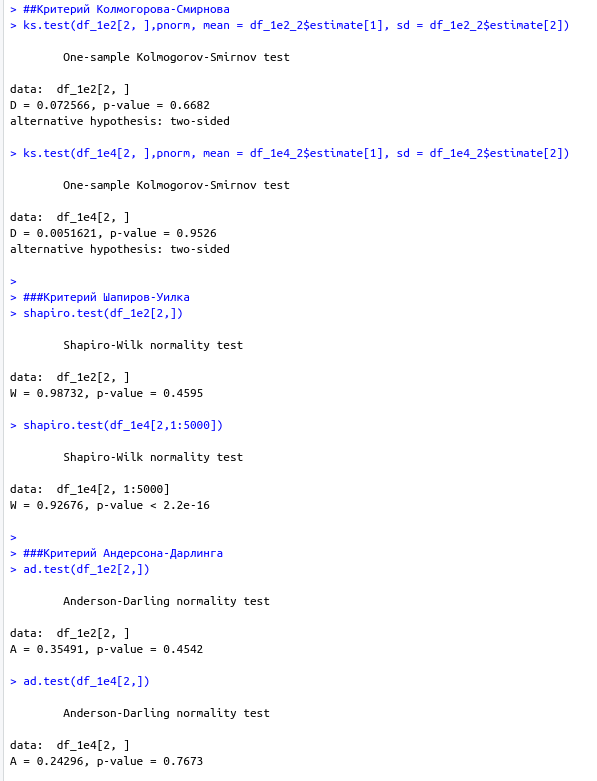

In [59]:
#N(5,5)
Image("./Screan_R/Task5_9.png")

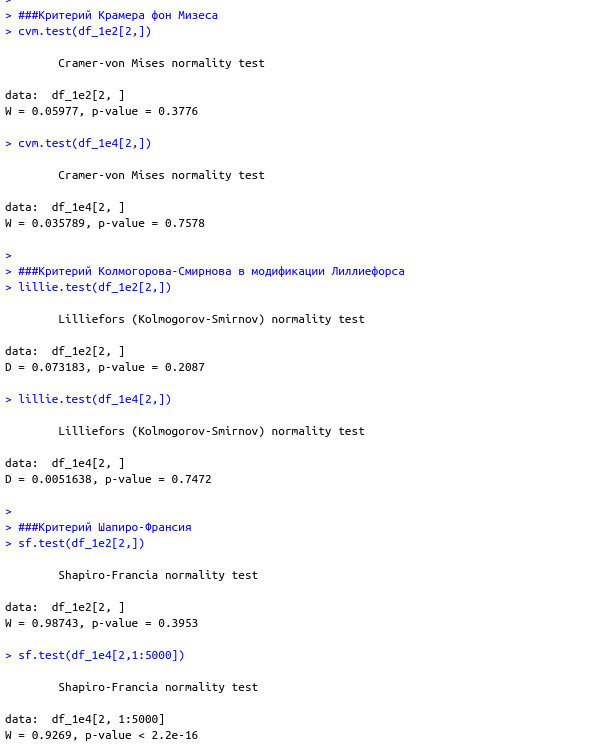

In [60]:
Image("./Screan_R/Task5_10.png")

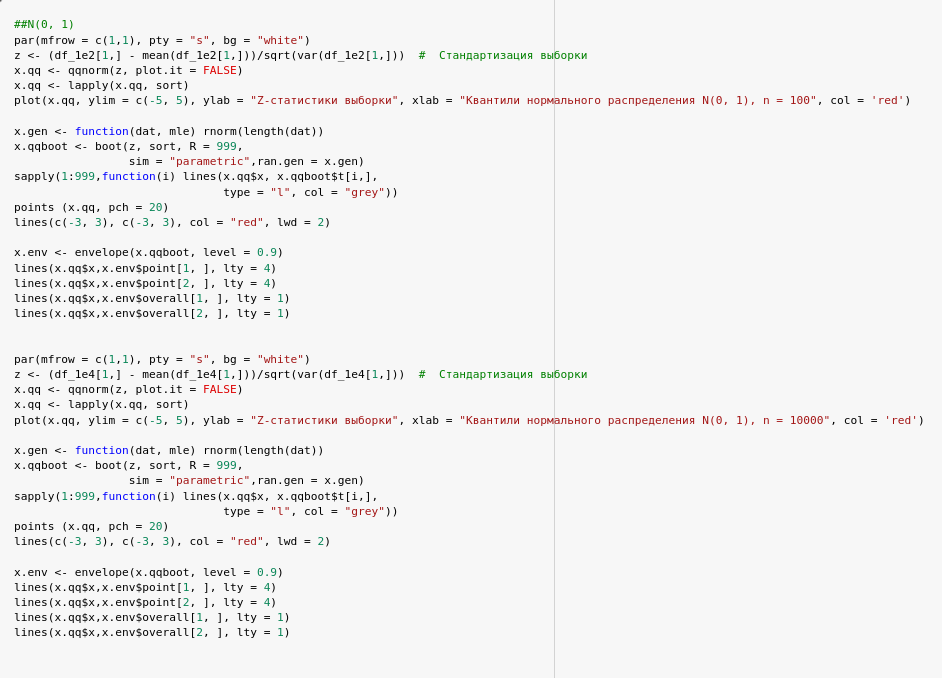

In [61]:
Image("./Screan_R/Task5_11.png")

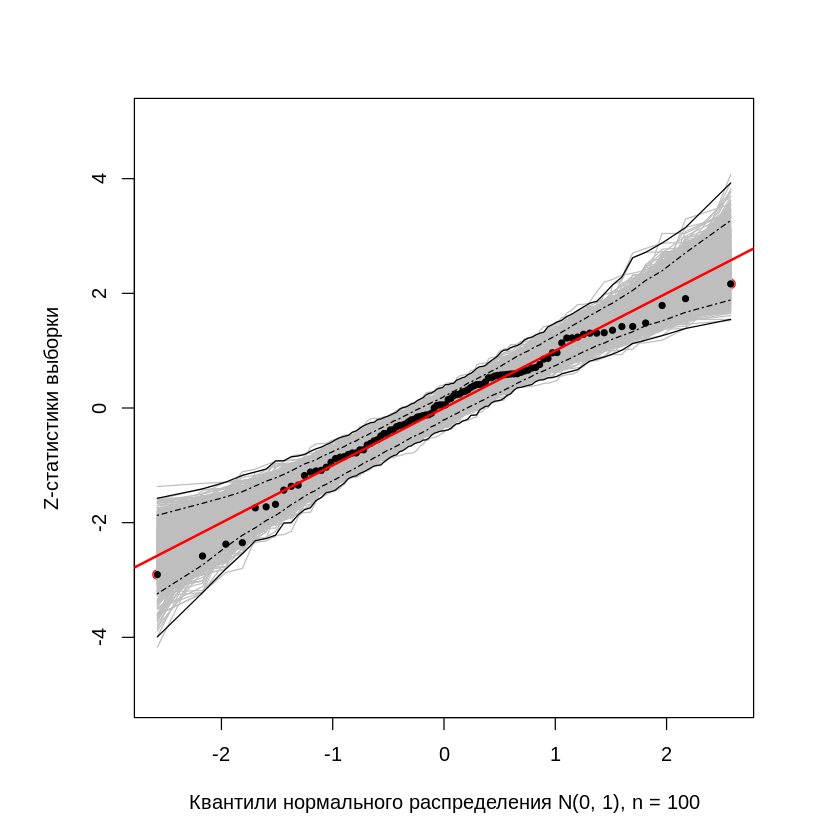

In [62]:
Image("./Screan_R/Task5_12.png")

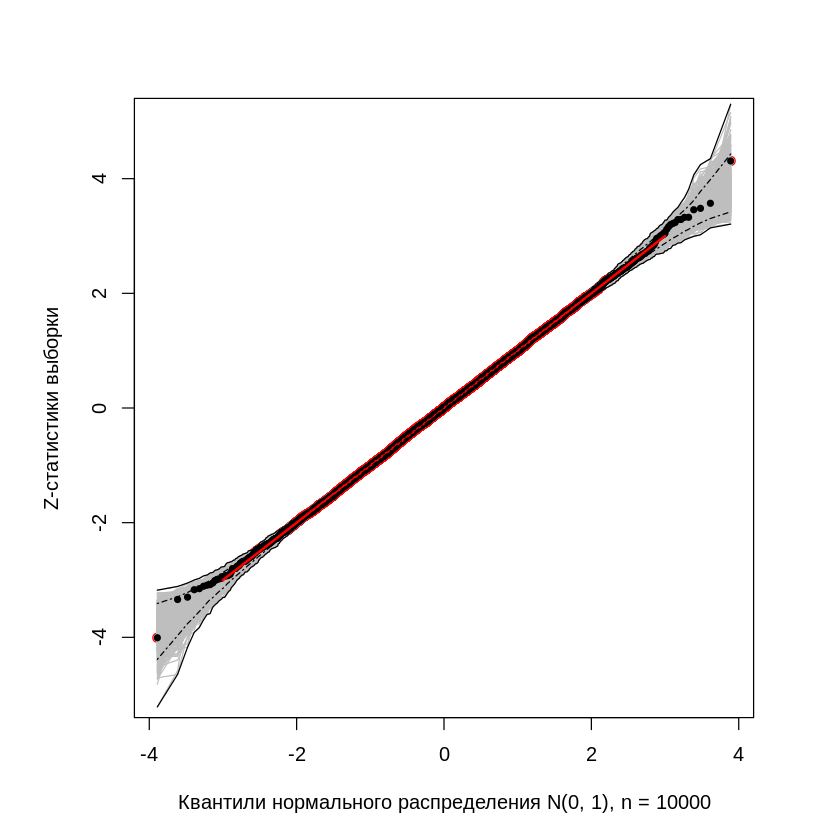

In [63]:
Image("./Screan_R/Task5_13.png")

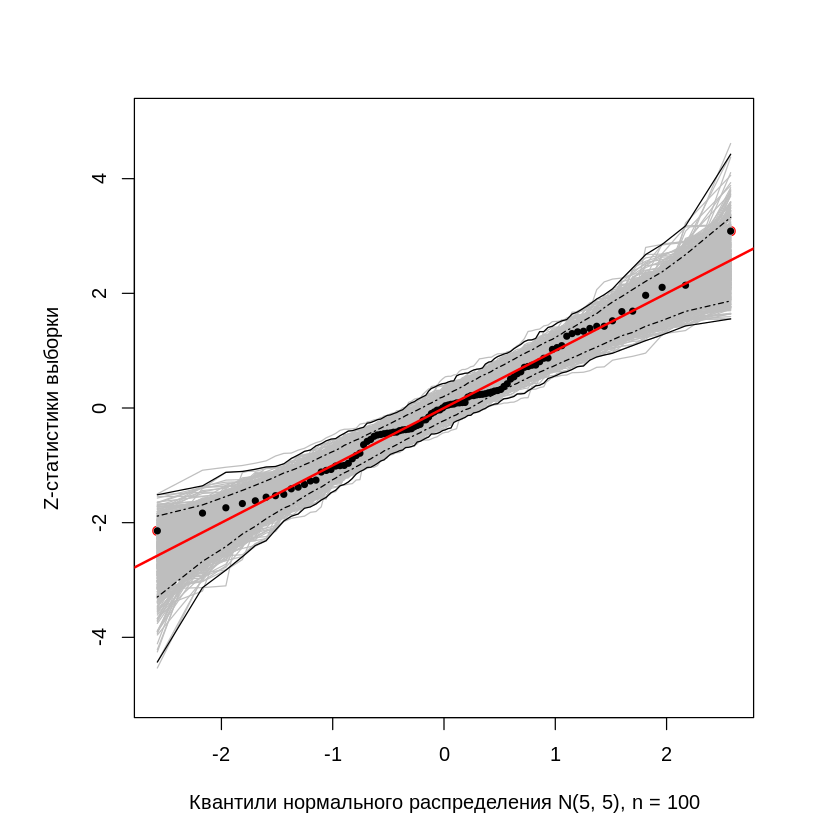

In [64]:
Image("./Screan_R/Task5_14.png")

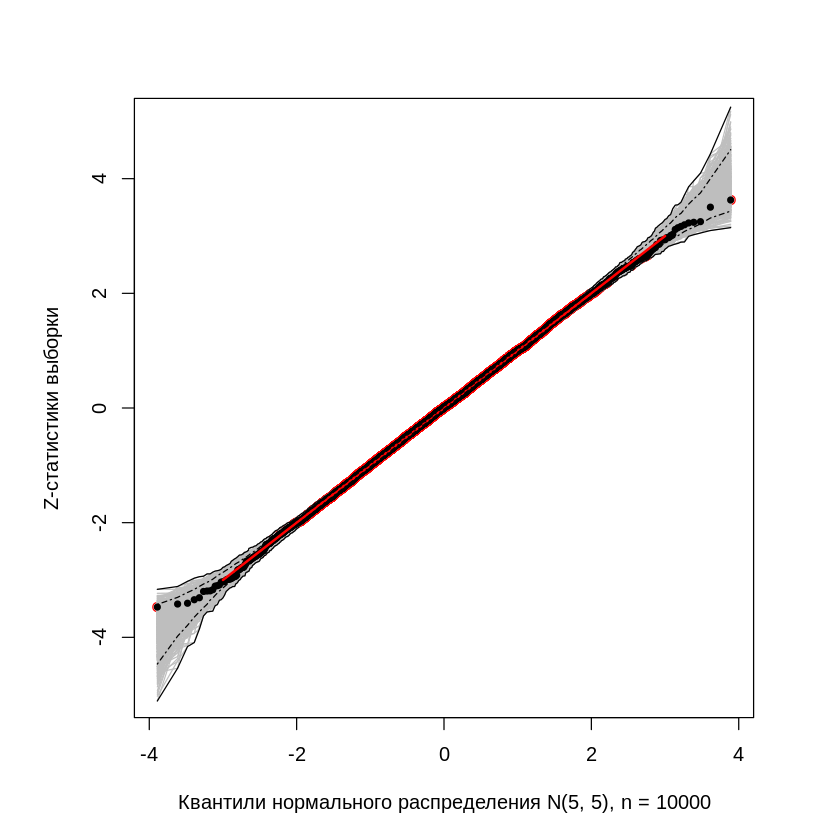

In [65]:
Image("./Screan_R/Task5_15.png")

Вывод: По графикам построенным графикам можно подтвердить нормальность выборки.
По полученным значениям p-value принимаем гипотезу о нормальности сгенерированных данных,
поскольку p-value для всех тестов больше критичсекого значения в 0.05. 

# Задание 6

Произведем аналогичные действия для нашего датасета, состоящего из котировок акций Яндекса. В качестве случайной велечины возьмем изменение за сутки.

In [66]:
df = pd.read_csv("YNDX_PRAC.csv")
df.head()

Date  Close   Open   High    Low  Volume  Delta  Vec
0  2011-05-25  35.00  37.75  37.90  34.40  11,76M  -2.75   -1
1  2011-05-26  34.77  34.45  35.45  34.00   4,42M   0.32    1
2  2011-05-27  34.45  34.75  35.00  34.00   2,01M  -0.30   -1
3  2011-05-31  33.45  34.95  35.37  32.61   3,98M  -1.50   -1
4  2011-06-01  32.25  32.98  33.07  32.00   3,72M  -0.73   -1

<AxesSubplot: xlabel='Delta', ylabel='Density'>

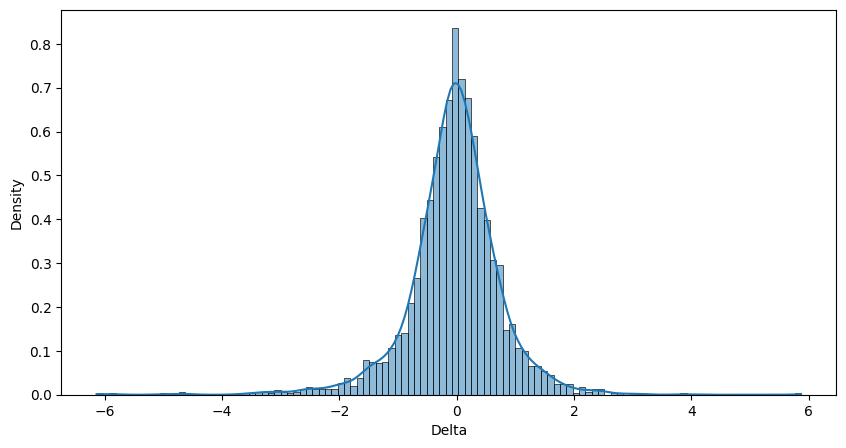

In [67]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

sns.histplot(data=df["Delta"], kde=True, stat='density')
# Дельта = цена закрытия - цена открытия

По графику характеристика Delta обладает схожими чертами с
нормальным распределением - рассмотрим эту гипотезу:

In [68]:
sd = df['Delta'].std()
m = df['Delta'].mean()
data_x = np.linspace(m - 10*sd, m + 10*sd, 1000)

In [69]:
data_y = norm.cdf(data_x)
data_50 = df['Delta'][:50]
data_3000 = df['Delta'][:3000]

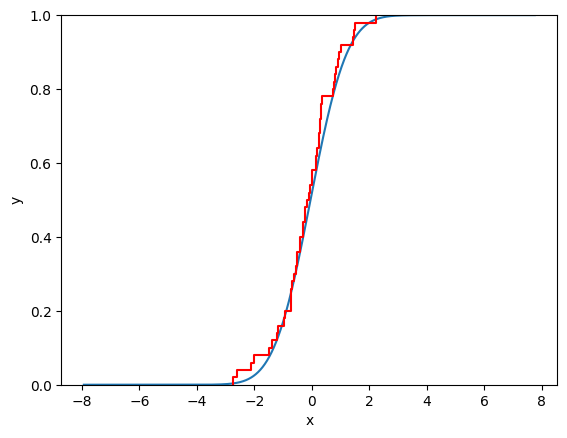

In [70]:
df = pd.DataFrame({ "x" : data_x + m, "y" : data_y})
sns.lineplot(x="x", y="y", data=df)
sns.ecdfplot(data_50, color = 'red')
plt.show()

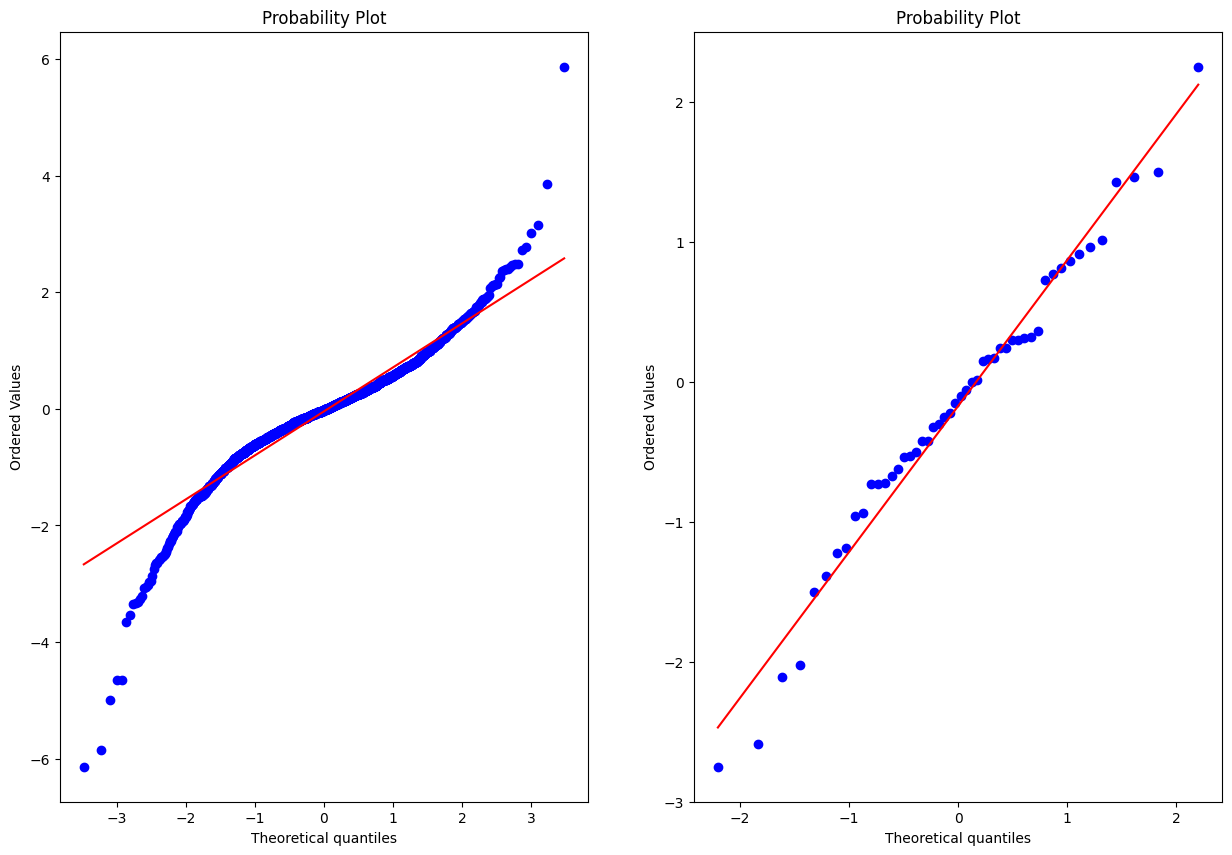

In [71]:
plt.figure(figsize = (15,10))
plt.subplot(1, 2, 1)
stats.probplot(data_3000, dist="norm", plot=plt)
plt.subplot(1, 2, 2)
stats.probplot(data_50, dist="norm", plot=plt)
plt.show()

По графикам видно, что распределение признака похоже на нормальное
распределение, проверим на тестах:

In [72]:
print(kstest(data_50, stats.norm.cdf))
print(shapiro(data_50))
print(anderson(data_50))
print(cramervonmises(data_50, stats.norm.cdf))
print(lilliefors(data_50))

KstestResult(statistic=0.13942356678200896, pvalue=0.2603282557321803)
ShapiroResult(statistic=0.9807685017585754, pvalue=0.5847991108894348)
AndersonResult(statistic=0.35397785738348375, critical_values=array([0.538, 0.613, 0.736, 0.858, 1.021]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
CramerVonMisesResult(statistic=0.13172688033622088, pvalue=0.4516806412888369)
(0.09396344030005804, 0.3317107147989811)


In [73]:
print(kstest(data_3000, stats.norm.cdf))
print(shapiro(data_3000))
print(anderson(data_3000))
print(cramervonmises(data_3000, stats.norm.cdf))
print(lilliefors(data_3000))

KstestResult(statistic=0.12763070930587905, pvalue=6.274026918954331e-39)
ShapiroResult(statistic=0.9275274276733398, pvalue=2.508072169879117e-34)
AndersonResult(statistic=36.84632116127705, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
CramerVonMisesResult(statistic=18.569989151478026, pvalue=3.695516670454424e-09)
(0.07930426728183451, 0.0009999999999998899)


Вывод: Все тесты над выборками маленького объема имеют p-value больше 0.05, а значит мы принимаем гипотезу о нормальности, а вот тесты над выбокой объемом n=3000 не все прошли. 

### R

Проделаем аналогичную работу на языке R:

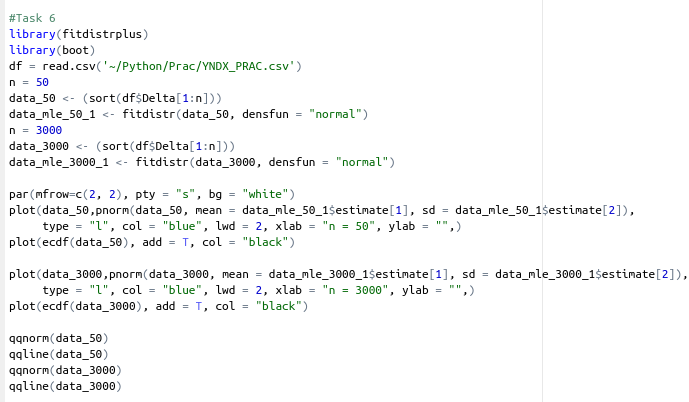

In [74]:
Image("./Screan_R/task6_code1.png")

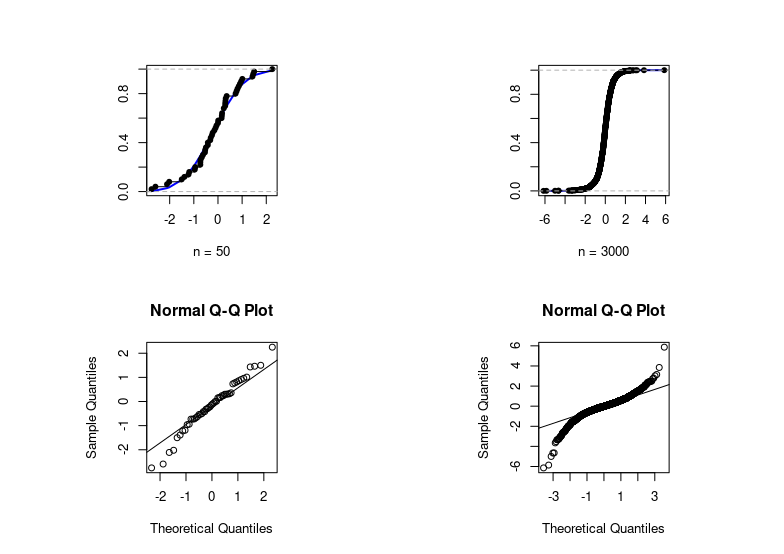

In [75]:
Image("./Screan_R/task6_1.png")

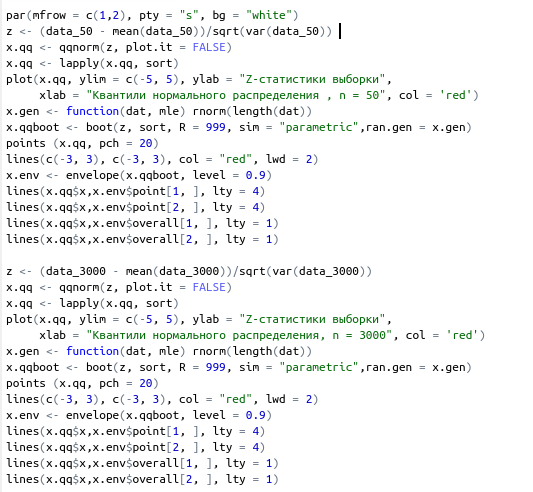

In [76]:
Image("./Screan_R/task6_code2.png")

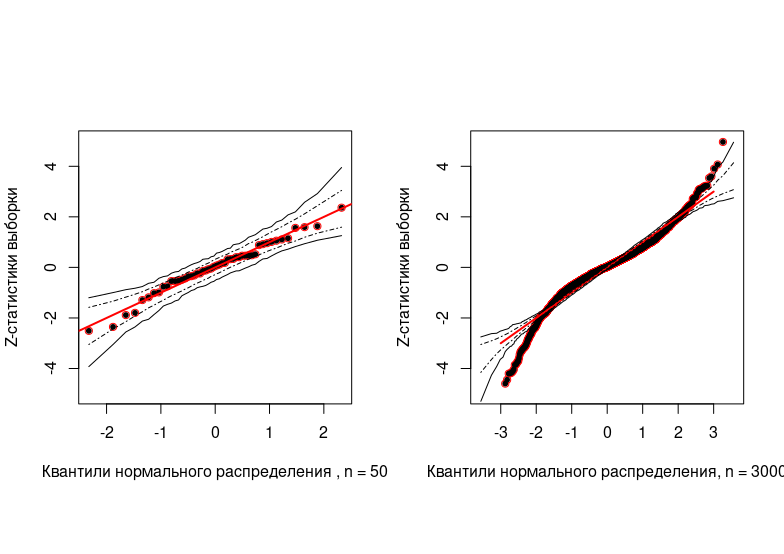

In [77]:
Image("./Screan_R/task6_2.png")

Выполним над данными требуемые тесты:

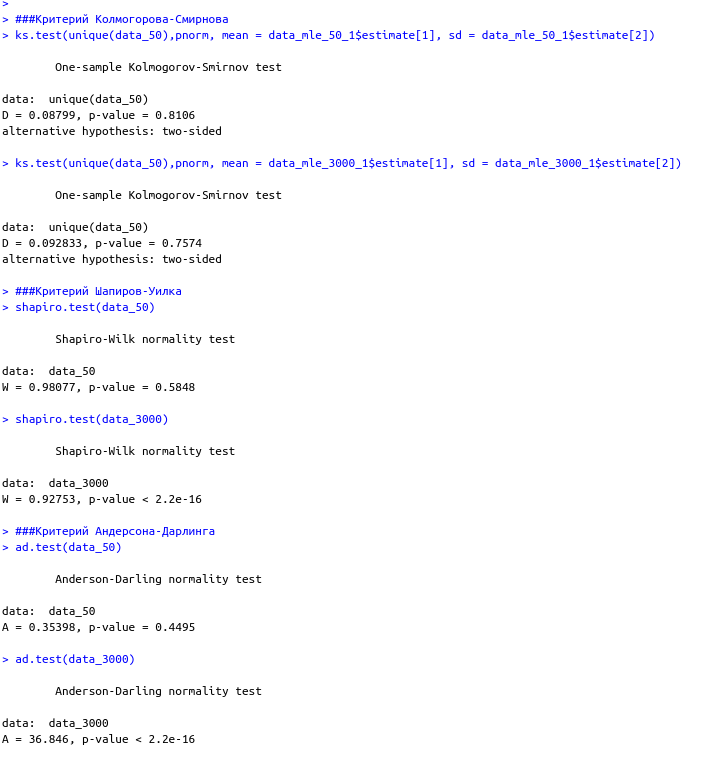

In [78]:
Image("./Screan_R/task6_1t.png")

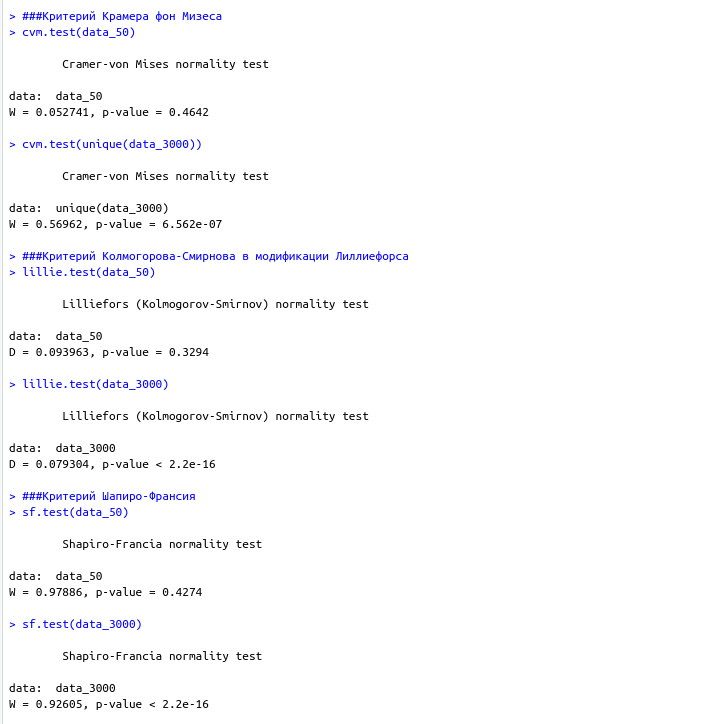

In [79]:
Image("./Screan_R/task6_2t.png")

Вывод: Результат такой же, как и в Python. Все тесты над выборками маленького объема имеют p-value больше 0.05, а значит мы принимаем гипотезу о нормальности, а вот тесты над выбокой объемом n=3000 прошли не все .

# Задание 7

Сгенерировав выборки из нормального распределения проверим гипотезы о средних значениях с помощью двустороннего и одностороннего T-критерия

In [92]:
df = df_fifa[quality_card].copy()

In [93]:
data1 = np.random.randn(1000) 
data2 = np.random.randn(1000) + 1 

# Двусторонний
stat, p = ttest_ind(data1, data2)
alpha = 0.05
print(("Принять" if p > alpha else "Отвергнуть") +  " H0")
 
stat, p = ttest_ind(data1, data2, alternative = 'less')
alpha = 0.05
print(("Принять" if p > alpha else "Отвергнуть") +  " H0")
 
stat, p = ttest_ind(data1, data2, alternative = 'greater')
alpha = 0.05
print(("Принять" if p > alpha else "Отвергнуть") +  "H0")

Отвергнуть H0
Отвергнуть H0
ПринятьH0


Полученные результаты отражают реальность, среднее второй выборки действительно больше, проверим на других выборках:

In [94]:
data1 = np.random.randn(1000) 
data2 = np.random.randn(1000)

# Двусторонний
stat, p = ttest_ind(data1, data2)
alpha = 0.1 
print(("Принять" if p > alpha else "Отвергнуть") +  " H0")
 
stat, p = ttest_ind(data1, data2, alternative = 'less')
alpha = 0.1
print(("Принять" if p > alpha else "Отвергнуть") +  " H0")
 
stat, p = ttest_ind(data1, data2, alternative = 'greater')
alpha = 0.1
print(("Принять" if p > alpha else "Отвергнуть") +  " H0")

Принять H0
Принять H0
Принять H0


In [95]:
data1 = np.random.randn(1000) - 1 
data2 = np.random.randn(1000)

# Двусторонний
stat, p = ttest_ind(data1, data2)
alpha = 0.1 
print(("Принять" if p > alpha else "Отвергнуть") +  " H0")
 
stat, p = ttest_ind(data1, data2, alternative = 'less')
alpha = 0.1
print(("Принять" if p > alpha else "Отвергнуть") +  " H0")
 
stat, p = ttest_ind(data1, data2, alternative = 'greater')
alpha = 0.1
print(("Принять" if p > alpha else "Отвергнуть") +  " H0")

Отвергнуть H0
Отвергнуть H0
Принять H0


С помощью следующих критериев рассмотрим схожесть распределний целевой
переменной SHO и DEF:

In [96]:
print(stats.levene(df_fifa['SHO'][1:50], df['DEF'][1:50], center = "mean"))
print(stats.bartlett(df['SHO'][1:50], df['DEF'][1:50]))
print(stats.fligner(df['SHO'][1:50], df['DEF'][1:50], center = "mean"))

LeveneResult(statistic=12.060916199687897, pvalue=0.0007738742673569178)
BartlettResult(statistic=5.042695554637417, pvalue=0.02472998030668151)
FlignerResult(statistic=12.586615131785607, pvalue=0.0003885191386516417)


По полученным результатам гипотеза об одинаковом рапсределении SHO и
DEF отвергается

### R

Применим критерий стьюдента для Ratings:

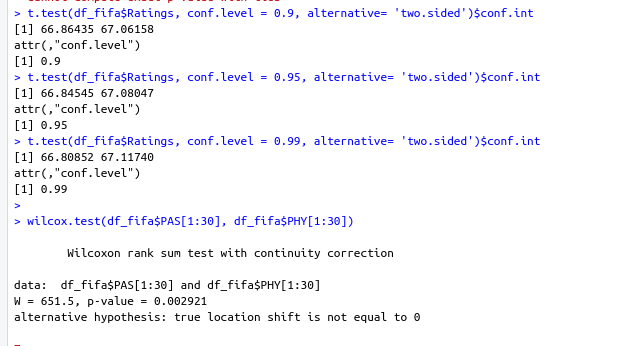

In [97]:
Image("./Screan_R/task7_R.png")

Получили интервалы для среднего для различных доверительных уровней.
Применили критерий Уилкоксона-Манна-Уитни для оценки среднего значения PAS и PHY.
По полученным результатам гипотеза об одинаковом среднем отвергается.

# Задание 8

Посмотрим на зависимость между Ratings характеристиками игроков, а также исследуем на корреляцию между между признаками PAC, SHO, PAS, DRI, DEF, PHY

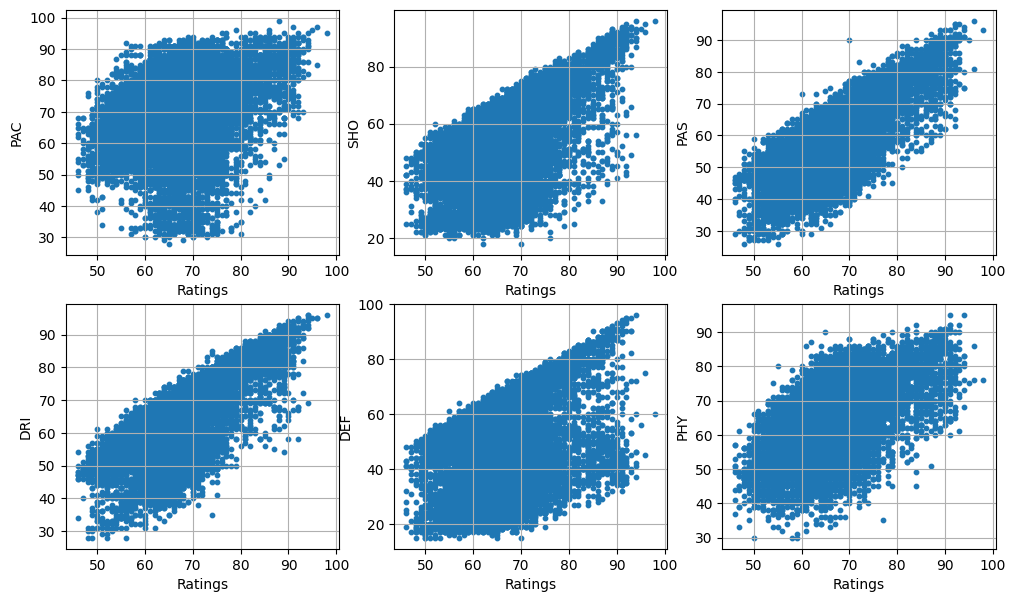

In [98]:
plt.figure(figsize=(12, 7))

for i in range(1, 7):
    
    plt.subplot(2, 3, i)
    plt.scatter(df_fifa[["Ratings"]], df_fifa[[quality_card[i - 1]]], s=10)
    plt.ylabel(i)
    plt.xlabel('Ratings')
    plt.ylabel(quality_card[i - 1])
    plt.grid(True) 
    
plt.show()

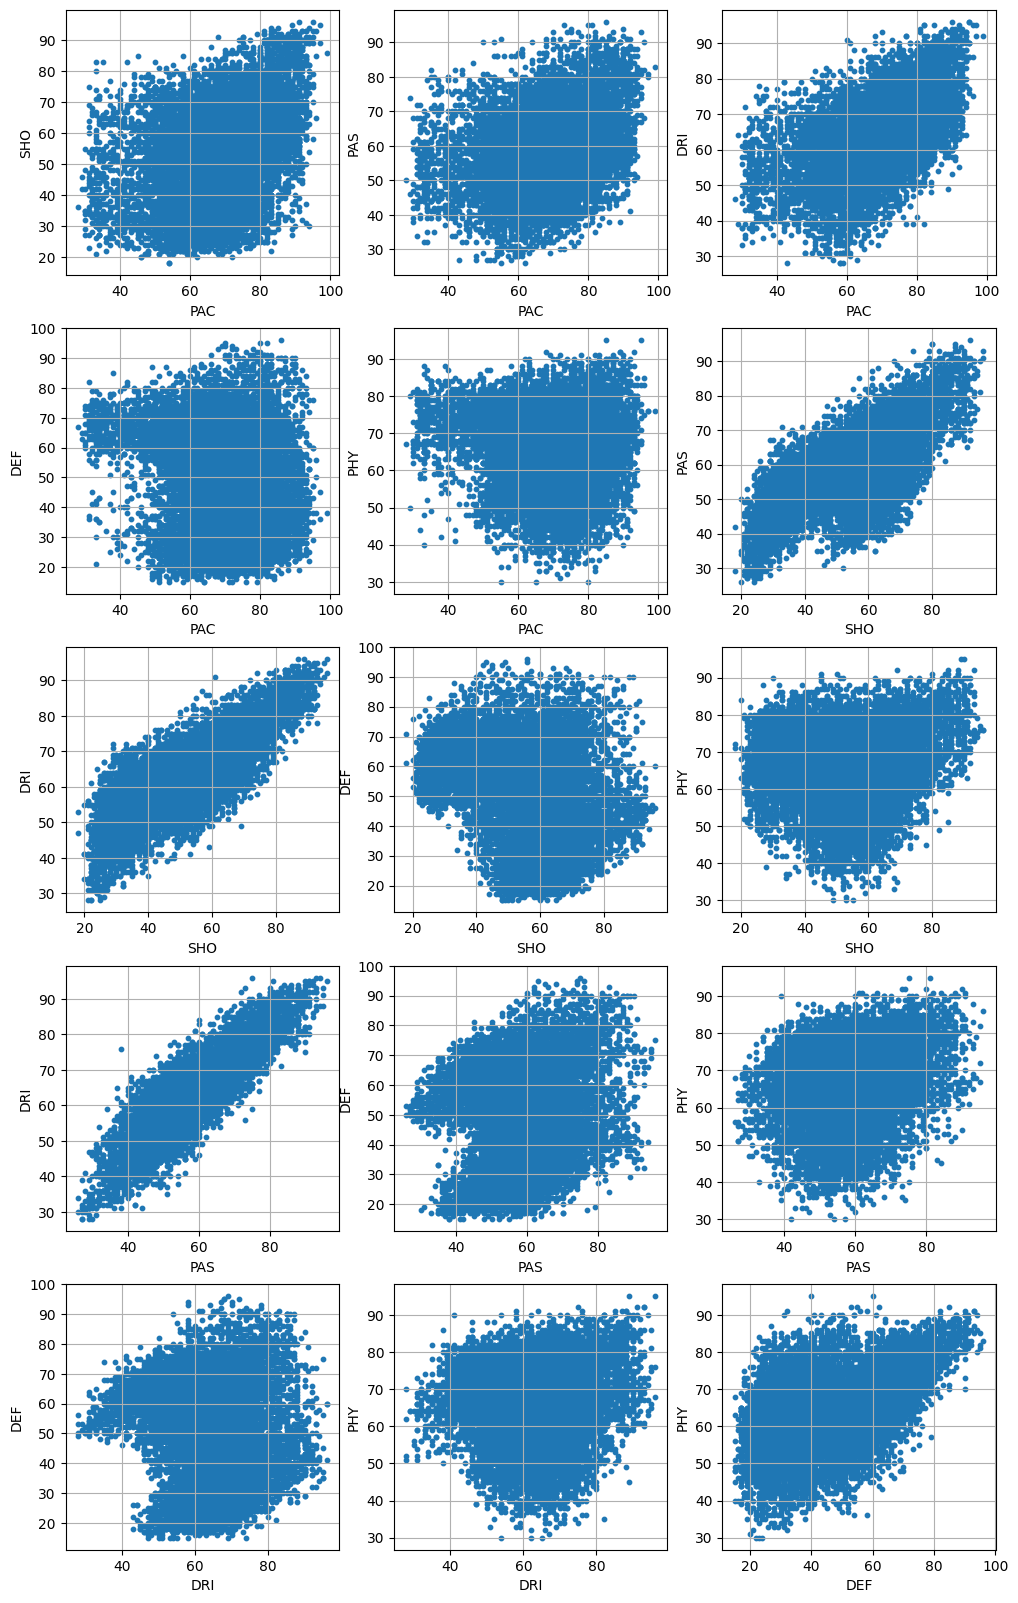

In [99]:
plt.figure(figsize=(12, 20))

index = 1
for i in range(len(quality_card)):
    for j in range(i + 1, len(quality_card)):
    
        plt.subplot(5, 3, index)
        plt.scatter(df_fifa[[quality_card[i]]], df_fifa[[quality_card[j]]], s=10)
        plt.ylabel(i)
        plt.xlabel(quality_card[i])
        plt.ylabel(quality_card[j])
        plt.grid(True) 
        
        index += 1
plt.show()

Из графиков видно, что зависимоcти между PAS, DRI, SHO, Ratings похожи на линейную.Проверим это предположение, посчитав коэфициенты Пирсона, Спирмена и Кендалла

In [100]:
#коэффициент корреляции Пирсона
for i in range(1, 7):
    cor = df_fifa["Ratings"].corr(df_fifa[quality_card[i - 1]])
    print("corrcoef Ratings ~ " + quality_card[i - 1] + " = ", cor)

print("---")

for i in range(len(quality_card)):
    for j in range(i + 1, len(quality_card)):
        cor = df_fifa[quality_card[i]].corr(df_fifa[quality_card[j]])
        print("corrcoef" + quality_card[i] + "~" + quality_card[j] + " = ", cor)

corrcoef Ratings ~ PAC =  0.32416882399797436
corrcoef Ratings ~ SHO =  0.5348613186334846
corrcoef Ratings ~ PAS =  0.7430683425943183
corrcoef Ratings ~ DRI =  0.72273666327085
corrcoef Ratings ~ DEF =  0.3550679045273421
corrcoef Ratings ~ PHY =  0.5734652030234993
---
corrcoefPAC~SHO =  0.36838852129326166
corrcoefPAC~PAS =  0.3241774173862232
corrcoefPAC~DRI =  0.5474421186918378
corrcoefPAC~DEF =  -0.18515282361554786
corrcoefPAC~PHY =  -0.05361690975399012
corrcoefSHO~PAS =  0.7110439484835526
corrcoefSHO~DRI =  0.7977976183913995
corrcoefSHO~DEF =  -0.36495263315440307
corrcoefSHO~PHY =  0.08192920170155046
corrcoefPAS~DRI =  0.8631409504231168
corrcoefPAS~DEF =  0.16747675707111584
corrcoefPAS~PHY =  0.22929311862444082
corrcoefDRI~DEF =  -0.07341548650489495
corrcoefDRI~PHY =  0.1214668589499996
corrcoefDEF~PHY =  0.5255321944552804


In [101]:
#коэффициент корреляции Спирмена
for i in range(1, 7):
    cor = spearmanr(df_fifa["Ratings"], df_fifa[quality_card[i - 1]])
    print("spearmanr Ratings ~ " + quality_card[i - 1] + " = ", cor[0])
    
print("---")
    
for i in range(len(quality_card)):
    for j in range(i + 1, len(quality_card)):
        cor = spearmanr(df_fifa[quality_card[i]], df_fifa[quality_card[j]])[0]
        print("spearmanr" + quality_card[i] + "~" + quality_card[j] + " = ", cor)

spearmanr Ratings ~ PAC =  0.3202261918623997
spearmanr Ratings ~ SHO =  0.5243279552479475
spearmanr Ratings ~ PAS =  0.710566913436733
spearmanr Ratings ~ DRI =  0.7193333296625011
spearmanr Ratings ~ DEF =  0.38765006313654055
spearmanr Ratings ~ PHY =  0.5696233761660403
---
spearmanrPAC~SHO =  0.35288845364758414
spearmanrPAC~PAS =  0.3130918138984714
spearmanrPAC~DRI =  0.5411118035380099
spearmanrPAC~DEF =  -0.1844515083962233
spearmanrPAC~PHY =  -0.038460286409957585
spearmanrSHO~PAS =  0.6766457262195675
spearmanrSHO~DRI =  0.7755807447791745
spearmanrSHO~DEF =  -0.37092138223227283
spearmanrSHO~PHY =  0.0817479517322552
spearmanrPAS~DRI =  0.8471125759321029
spearmanrPAS~DEF =  0.16227134152548212
spearmanrPAS~PHY =  0.20769532773436727
spearmanrDRI~DEF =  -0.06208090852806964
spearmanrDRI~PHY =  0.11358647077615248
spearmanrDEF~PHY =  0.5441372234486421


In [102]:
#коэффициент корреляции Кендалла
for i in range(1, 7):
    cor = kendalltau(df_fifa["Ratings"], df_fifa[quality_card[i - 1]])
    print("kendalltau Ratings ~ " + quality_card[i - 1] + " = ", cor[0])
    
print("---")

for i in range(len(quality_card)):
    for j in range(i + 1, len(quality_card)):
        cor = kendalltau(df_fifa[quality_card[i]], df_fifa[quality_card[j]])[0]
        print("kendalltau" + quality_card[i] + "~" + quality_card[j] + " = ", cor)

kendalltau Ratings ~ PAC =  0.22729285770408497
kendalltau Ratings ~ SHO =  0.39519716052460635
kendalltau Ratings ~ PAS =  0.5474370499552921
kendalltau Ratings ~ DRI =  0.5692788158351231
kendalltau Ratings ~ DEF =  0.30291237335632587
kendalltau Ratings ~ PHY =  0.41959590826457527
---
kendalltauPAC~SHO =  0.24711980757194002
kendalltauPAC~PAS =  0.219096447923281
kendalltauPAC~DRI =  0.39046996961775404
kendalltauPAC~DEF =  -0.1282145483734227
kendalltauPAC~PHY =  -0.026323373204880162
kendalltauSHO~PAS =  0.5141037428476273
kendalltauSHO~DRI =  0.6017198634915416
kendalltauSHO~DEF =  -0.2429244422119028
kendalltauSHO~PHY =  0.06202696228722677
kendalltauPAS~DRI =  0.6813988494903565
kendalltauPAS~DEF =  0.11582147075062467
kendalltauPAS~PHY =  0.14647683630909872
kendalltauDRI~DEF =  -0.038612796483149685
kendalltauDRI~PHY =  0.08072958358503773
kendalltauDEF~PHY =  0.39783578134890873


Действительно, лучше всего коррелируются такие признаки, как SHO, PAS, DRI, что подтверждает выдвинутое предположение по графику.
По 3-м видам коэффициентов лучше всего коррелируют признаки PAS и DRI

### R:

Проведем аналогичное исследование на языке R

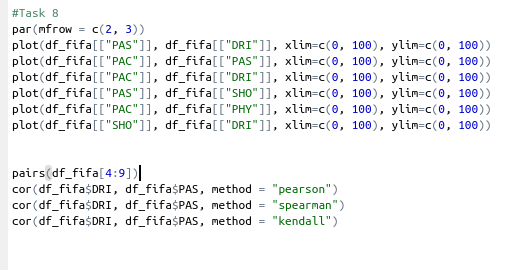

In [103]:
Image("./Screan_R/Task8_code.png")

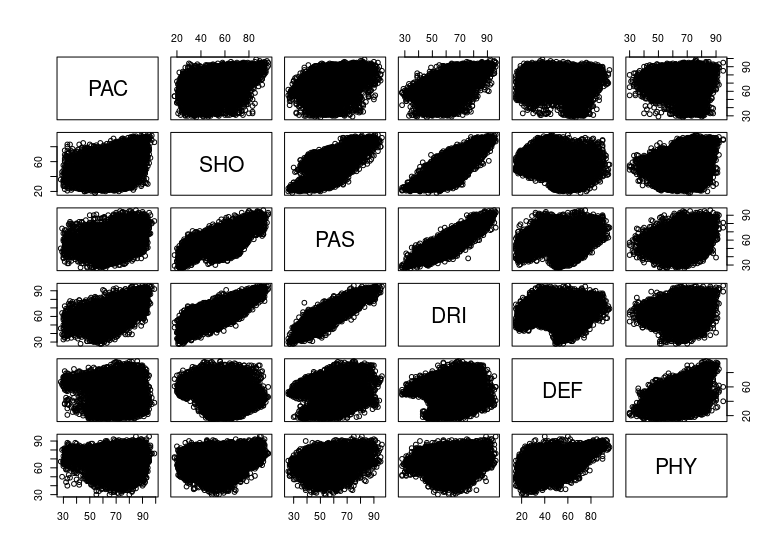

In [104]:
Image("./Screan_R/Task8.png")

Посчитаем некоторые коэффициенты корреляции:

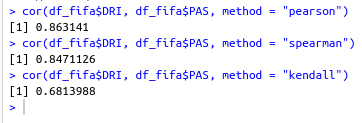

In [105]:
Image("./Screan_R/Task8_code_2.png")

Вывод: Больше всего коррелируют признаки DRI, PAS, SHO, что показывают все коэффициенты.

# Задание 9

In [106]:
a = df_fifa[(df_fifa["Country"] == "Brazil") & (df_fifa["Ratings"] > 85)].shape[0]
b = df_fifa[(df_fifa["Country"] == "Brazil") & (df_fifa["Ratings"] <= 85)].shape[0]
c = df_fifa[(df_fifa["Country"] == "Germany") & (df_fifa["Ratings"] > 85)].shape[0]
d = df_fifa[(df_fifa["Country"] == "Germany") & (df_fifa["Ratings"] <= 85)].shape[0]
df_test_fishera = pd.DataFrame({"Brazil" : [a, b], "Germany" : [c, d]}, index=[">85", "<=85"])

In [107]:
df_test_fishera

Brazil  Germany
>85       44       36
<=85     378     1171

In [108]:
fisher_exact(df_test_fishera)

(3.786302175191064, 2.1708715713620293e-08)

Проведя тест Фишера, мы отвергаем гипотезу о том, что среди футболистов из Германии статистически чаще втречаются игроки с высоким рейтингом, чем в Бразилии

Хи-квадрат критерий
Возьмем в качестве данных котировки акций Яндекса (посуточно) и предположим, 
что количество подряд идущих свечей зеленого цвета имеет отрицательное биномиальное распределение
Данные обработал в другом файле


Delta - изменение за сутки
Vec - цвет свечи

In [109]:
df4 = pd.read_csv("./YNDX_3.csv")
df4.head()

Unnamed: 0  Delta  Vec
0  2011-05-25  -2.75   -1
1  2011-05-26   0.32    1
2  2011-05-27  -2.53   -3
3  2011-06-02   2.00    4
4  2011-06-08  -3.11   -4

In [110]:
from scipy.stats import nbinom

In [111]:
observed = df4[df4["Vec"] > 0]["Vec"] - 1
mean = observed.mean()
var = observed.var()

# param:
p = mean / var  
r = p * mean / (1 - p)

expected = nbinom.rvs(r, p, size = len(observed))

[]

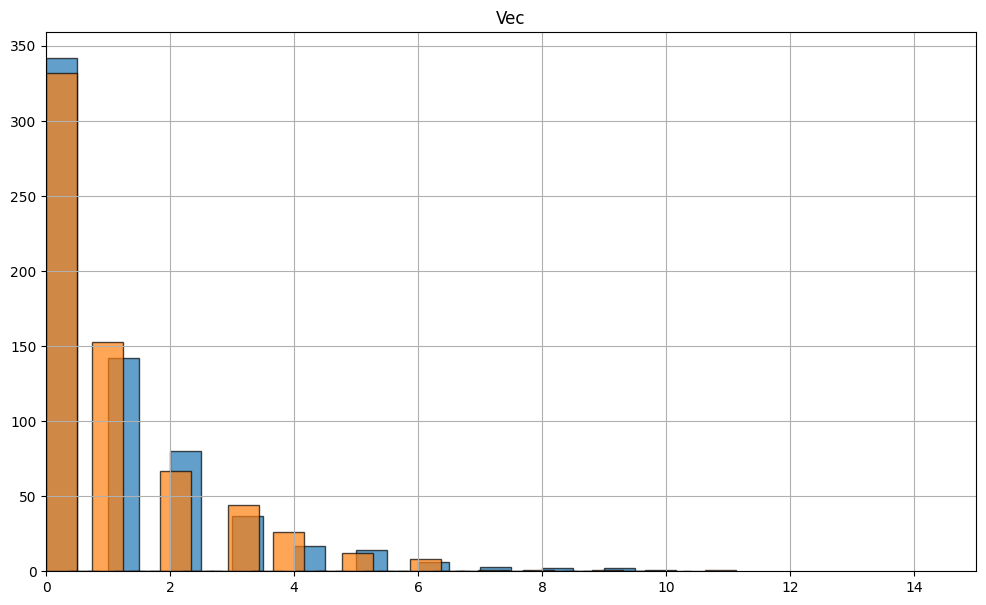

In [112]:
plt.figure(figsize=(12, 7))

plt.title("Vec")
plt.hist(expected,  bins=30, width=0.5, edgecolor='black', alpha=0.7)
plt.xlim(0, 15)
plt.grid(True) 

plt.title("Vec")
plt.hist(observed,  bins=30, width=0.5, edgecolor='black', alpha=0.7)
plt.xlim(0, 15)
plt.grid(True) 


plt.plot()

In [113]:
n = max(observed)
f_obs = np.zeros(n)
for i in range(n):
    f_obs[i] =  np.sum(observed == i)
f_exp = np.zeros(n)
for i in range(n):
    f_exp[i] = nbinom.pmf(i, r, p) * len(observed)
f_exp[0] += sum(f_obs) - sum(f_exp)  # уравнивание частот

In [114]:
from scipy.stats import chisquare
chisquare(f_obs, f_exp)

Power_divergenceResult(statistic=6.083989244943824, pvalue=0.808158136303555)

Принимаем гипотезу о том, что количество подряд идущих свечей положительного тренда имеет биномиальное распределение, т.к. p-value > 0.05

Аналогично проверим для красных свечей

In [115]:
observed = df4[df4["Vec"] < 0]["Vec"].apply(abs) - 1
mean = observed.mean()
var = observed.var()

# param:
p = mean / var  
r = p * mean / (1 - p)
expected = nbinom.rvs(r, p, size = len(observed))

[]

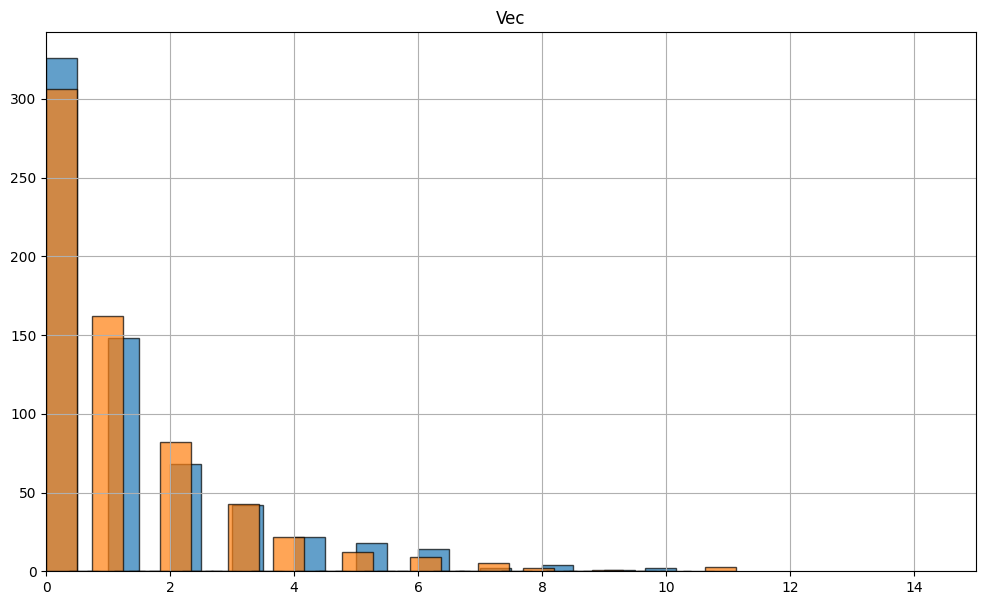

In [116]:
plt.figure(figsize=(12, 7))

plt.title("Vec")
plt.hist(expected,  bins=30, width=0.5, edgecolor='black', alpha=0.7)
plt.xlim(0, 15)
plt.grid(True) 

plt.title("Vec")
plt.hist(observed,  bins=30, width=0.5, edgecolor='black', alpha=0.7)
plt.xlim(0, 15)
plt.grid(True) 


plt.plot()

In [117]:
n = max(observed)
f_obs = np.zeros(n)
for i in range(n):
    f_obs[i] =  np.sum(observed == i)
f_exp = np.zeros(n)
for i in range(n):
    f_exp[i] = nbinom.pmf(i, r, p) * len(observed)
f_exp[0] += sum(f_obs) - sum(f_exp)

In [118]:
chisquare(f_obs, f_exp)

Power_divergenceResult(statistic=2.8596572701053997, pvalue=0.9845364544795683)

Принимаем гипотезу о том, что количество подряд идущих свечей красного цвета имеет биномиальное распределение, т.к. p-value > 0.05

### R

Проверим независимость среди признаков PAC, PAS, SHO, DRI, DEF, PHY, а также между country и Ratings с помощью критерия хи-квадрат

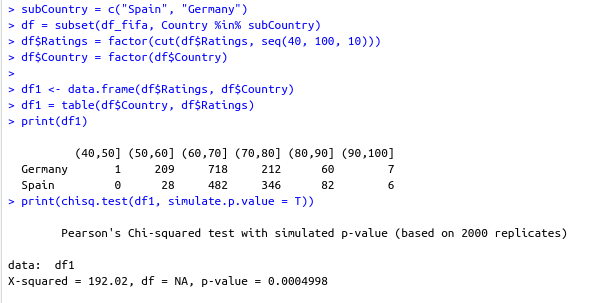

In [119]:
Image("Screan_R/task9_1.png")

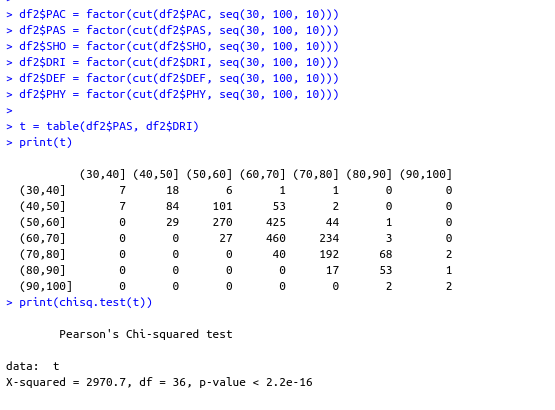

In [120]:
Image("Screan_R/task_9.png")

Во всех тестах значение p-value меньше 0.05, а значит мы отвергаем гипотезу о их незавсисмости. Достаточно логично, что игром не может иметь только хороший дриблинг, или другой признак. Обычно игроки универсальные и их значения характеристик отличаются незначительно, причем на разницу влияет позиция игрока.

# Задание 10

Построим корреляционную матрицу для признаков PAC, SHO, PAS, DRI, DEF, PHY

In [121]:
corr = df_fifa[quality_card].corr()
corr.style.background_gradient(cmap='RdYlGn')

In [122]:
#calculate VIF for each explanatory variable
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(df_fifa[quality_card], i) for i in range(len(quality_card))]
vif['variable'] = quality_card
vif

VIF variable
0   56.672440      PAC
1   81.397605      SHO
2  217.237472      PAS
3  317.206595      DRI
4   33.476523      DEF
5   56.920335      PHY

### R

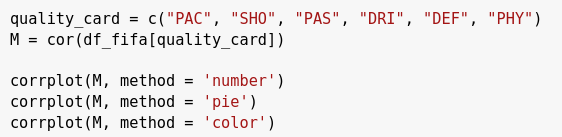

In [123]:
Image("./Screan_R/Task10_code.png")

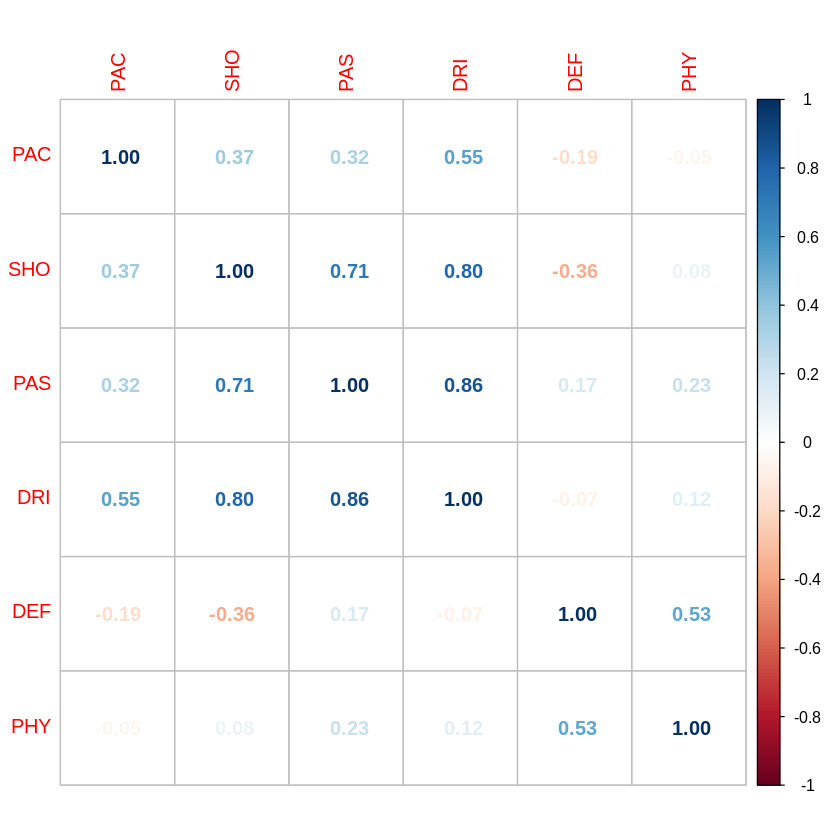

In [124]:
Image("./Screan_R/Task10_1.png")

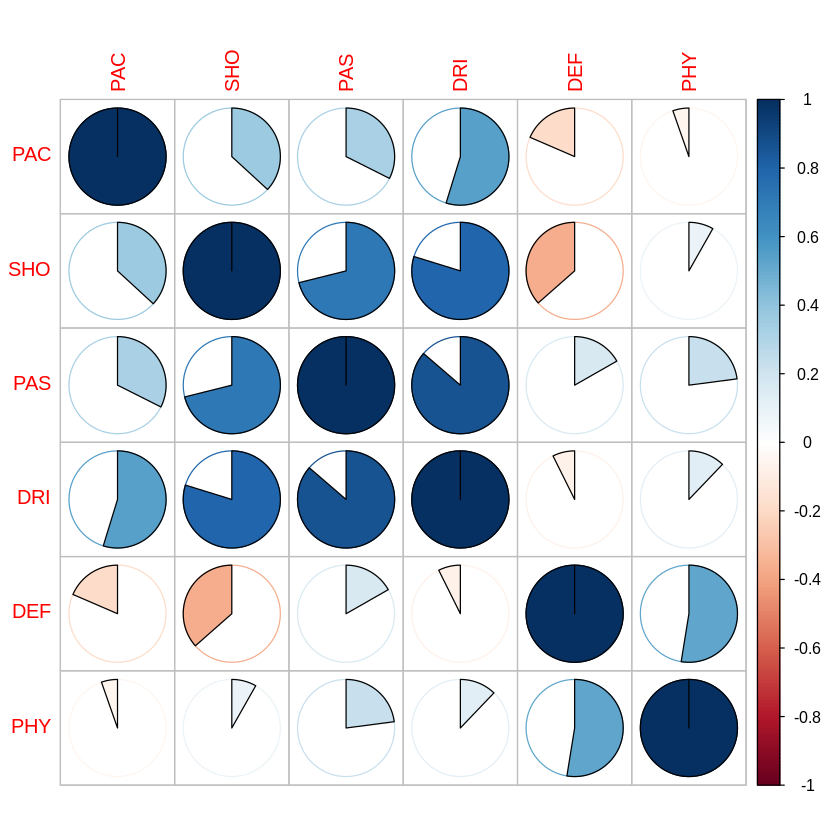

In [125]:
Image("./Screan_R/Task10_2.png")

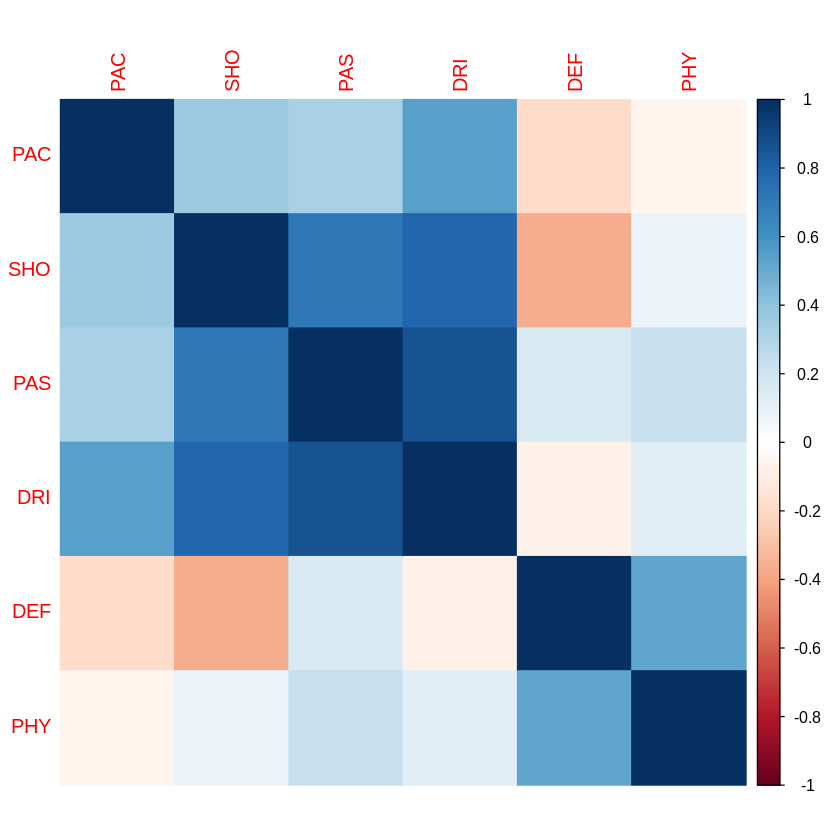

In [126]:
Image("./Screan_R/Task10_3.png")

Вывод: Исследуя факторы инфляции дисперсии, можно сказать, что характеристика между игроками мультиколлеарны. В реальности редко встречаются игроки, у которых характеристики сильно отличаются. Например, если игрок имеет хороший дриблинг, удар, защиту, маловероятно, что его физическая форма будет низкой.

# Задание 11

### R

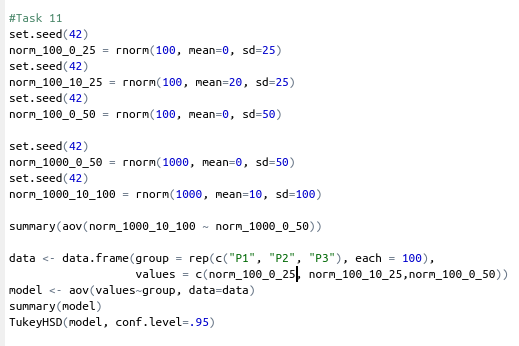

In [127]:
Image("./Screan_R/Task11_1.png")

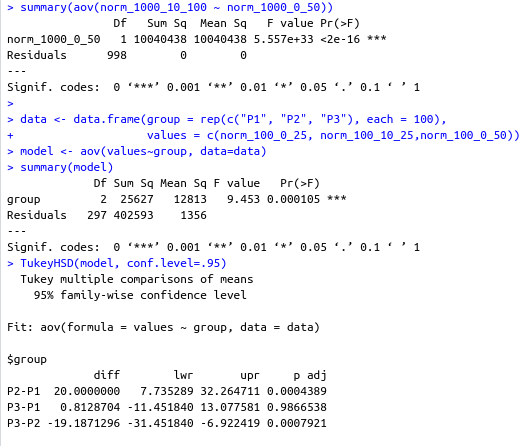

In [128]:
Image("./Screan_R/Task11_2.png")

В первом примере мы отвергаем нулевую гипотезу (p_value < 0.05), при это средние действительно не совпадают
Во втором случае результаты также отражают действительность. Используем тест на реальных данных:

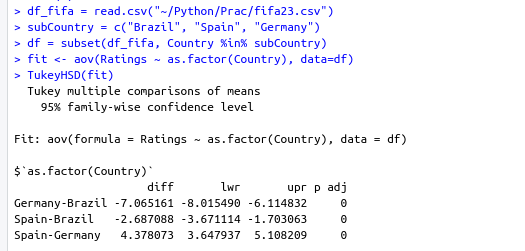

In [129]:
Image("./Screan_R/Task11.png")

In [130]:
print(df_fifa[df_fifa["Country"] == "Brazil"][["Ratings"]].mean())
print(df_fifa[df_fifa["Country"] == "Germany"][["Ratings"]].mean())
print(df_fifa[df_fifa["Country"] == "Spain"][["Ratings"]].mean())

Ratings    73.616114
dtype: float64
Ratings    66.550953
dtype: float64
Ratings    70.929025
dtype: float64


Результат совпадают с действительностью.
Выполним однофакторный дисперсионный анализ:

In [131]:
from scipy.stats import f_oneway
for col in quality_card:
    print(col, f_oneway(df_fifa.Ratings, df_fifa[col]))

PAC F_onewayResult(statistic=257.85180861215304, pvalue=8.37245694902774e-58)
SHO F_onewayResult(statistic=8919.691981318592, pvalue=0.0)
PAS F_onewayResult(statistic=6000.332328255694, pvalue=0.0)
DRI F_onewayResult(statistic=781.3757403074344, pvalue=5.901295330288449e-170)
DEF F_onewayResult(statistic=12499.19638979118, pvalue=0.0)
PHY F_onewayResult(statistic=128.7173246742514, pvalue=8.883926846257167e-30)


Отвергаем гипотезу о том, что переменные имеют одинаковое среднее значение во всех тестах

# Задание 12

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Построим линейную модель для Ratings, зависящую от признаков PAC, PAS, SHO, DRI, DEF, PHY:

In [133]:
X = df_fifa[["PAC", "SHO", "PAS", "DRI", "DEF", "PHY","Height", "Weight"]]
y = df_fifa[["Ratings"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [134]:
model = LinearRegression()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

In [135]:
r2_score(y_predict, y_test)

0.7483119862150132

Качество такой модели не высокое: r2_score меньше 0.9. Попробую использовать нелинейную модель (gradient boosting trees algorithm)

In [136]:
import xgboost
from xgboost import XGBRegressor

In [137]:
y_predict = pd.DataFrame(y_predict, columns=['Predict'], index=y_test.index)
result = pd.concat([y_test, y_predict], axis=1)
result = pd.concat([result, pd.DataFrame(result["Ratings"] - result["Predict"], columns=["Delta"])], axis=1)
result

Ratings    Predict     Delta
2628        74  71.141467  2.858533
183         89  85.782785  3.217215
1161        79  71.771501  7.228499
12321       62  61.245038  0.754962
5630        69  68.665791  0.334209
...        ...        ...       ...
12633       62  63.743215 -1.743215
13504       61  65.945243 -4.945243
4256        71  65.859237  5.140763
4960        70  70.981983 -0.981983
15148       57  54.254796  2.745204

[4111 rows x 3 columns]

In [139]:
xgb_reg = XGBRegressor(
                        n_estimators=10,
                        max_depth=10,
                        learning_rate=0.4,
                      )

xgb_reg.fit(X_train, y_train)
y_predict = xgb_reg.predict(X_test)

r2_score(y_test, y_predict)

0.9642556889137103

Точность заметно выросла, модель оказалась лучше, чем модель линейной регрессии

In [140]:
y_predict = pd.DataFrame(y_predict, columns=['Predict'], index=y_test.index)
result = pd.concat([y_test, y_predict], axis=1)
result = pd.concat([result, pd.DataFrame(result["Ratings"] - result["Predict"], columns=["Delta"])], axis=1)
result

Ratings    Predict     Delta
2628        74  73.166542  0.833458
183         89  87.525902  1.474098
1161        79  78.172348  0.827652
12321       62  60.273617  1.726383
5630        69  68.344551  0.655449
...        ...        ...       ...
12633       62  62.081463 -0.081463
13504       61  61.741028 -0.741028
4256        71  70.423500  0.576500
4960        70  69.193657  0.806343
15148       57  57.546665 -0.546665

[4111 rows x 3 columns]

### R:

Для начала попробуем выполнить автоподбор модели для Ratings, зависящей от DRI (признак, который лучше всего коррелировал с Ratings), основываясь на том, что все качества игроков коррелируют

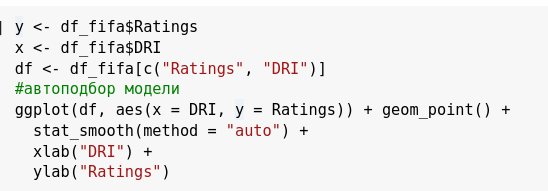

In [141]:
Image("./Screan_R/Task12_R_code1.png")

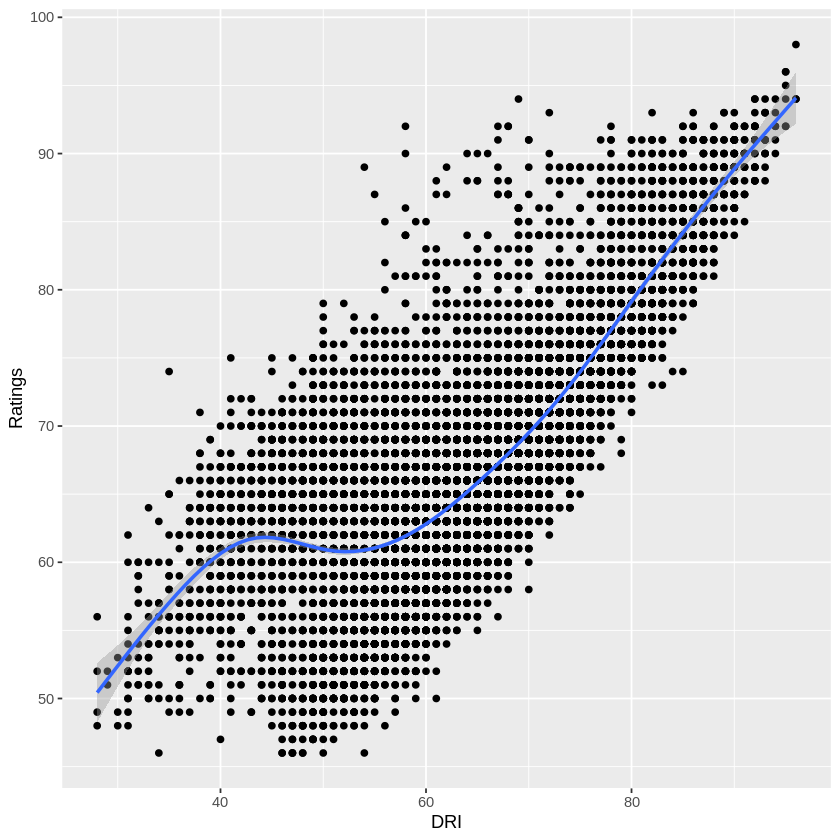

In [142]:
Image("./Screan_R/Task12_R_1.png")

Далее построим линейную модель для Ratings, зависящую от PAC, DRI, SHO, DEF, PAS, PHY:

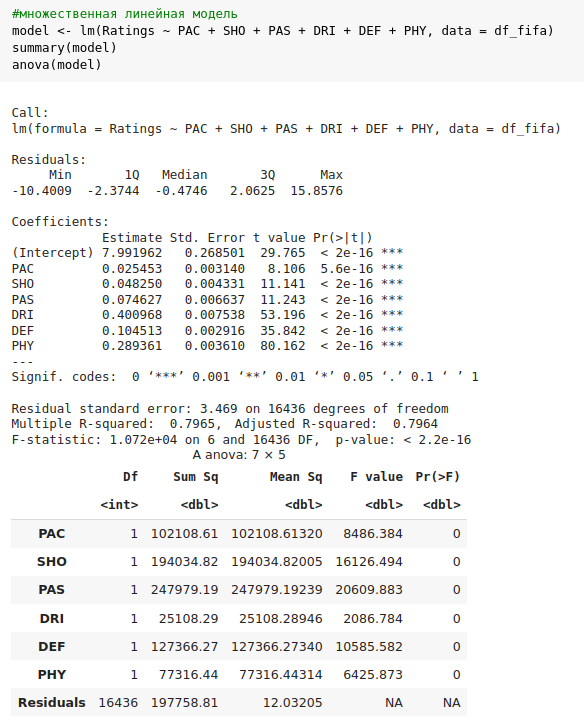

In [143]:
Image("./Screan_R/Task12_R_code2.png")

Получили, что линейная модель имеет точность на тестовых данных равную 0.7965

Построим линейную модель для Ratings, зависящую от DRI (признак, который лучше всего коррелировал с Ratings)

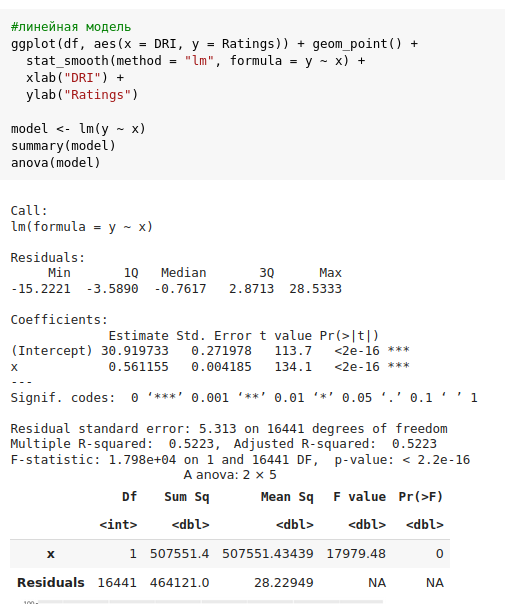

In [144]:
Image("./Screan_R/Task12_R_code4.png")

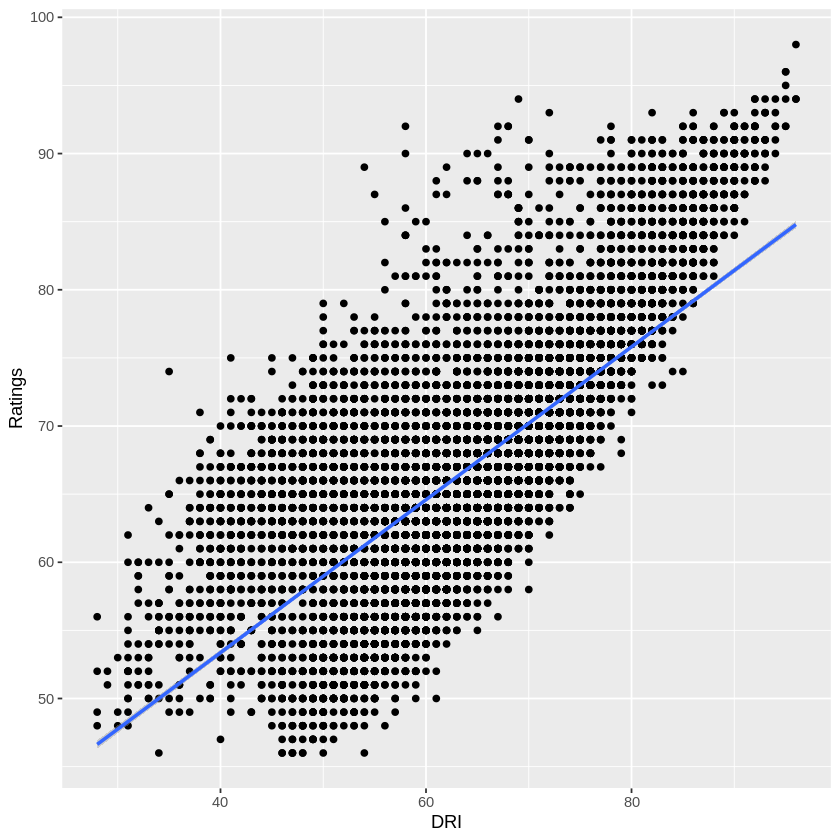

In [145]:
Image("./Screan_R/Task12_R_2.png")

Получили, что линейная модель имеет точность на тестовых данных равную 0.5313
Построим модель для Ratings, зависящую от квадрата DRI (признак, который лучше всего коррелировал с Ratings)

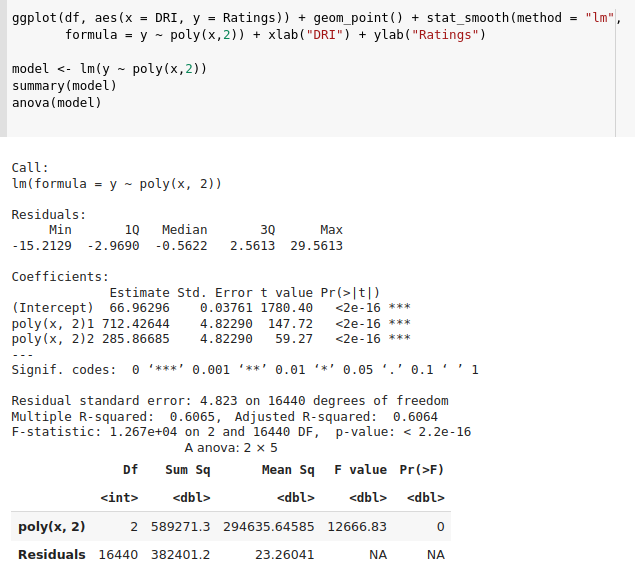

In [146]:
Image("./Screan_R/Task12_R_code5.png")

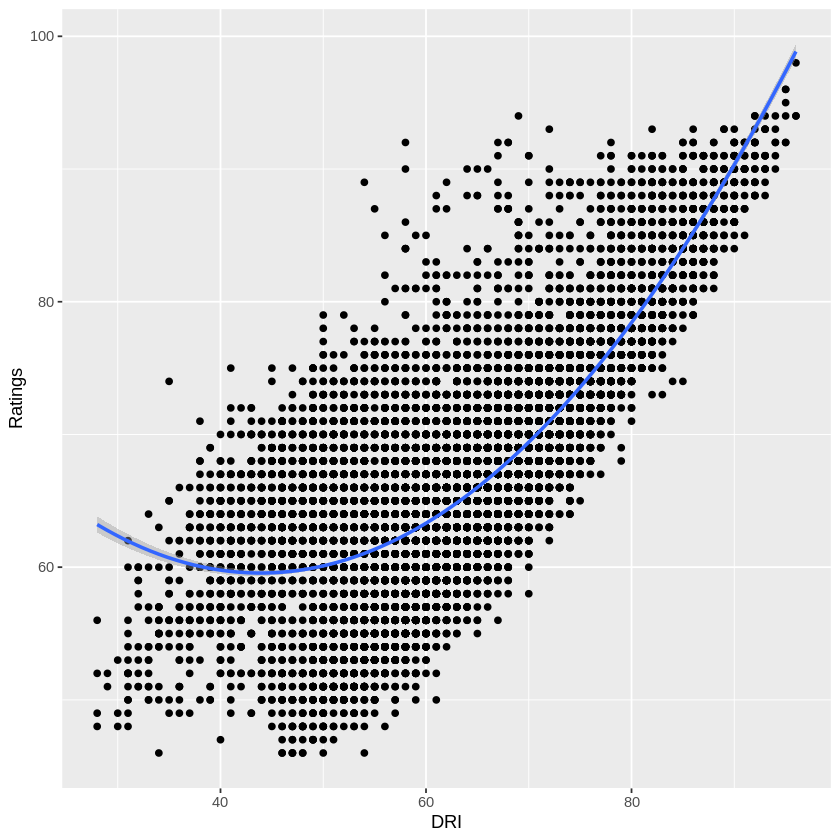

In [147]:
Image("./Screan_R/Task12_R_3.png")

Получили, что линейная модель имеет точность на тестовых данных равную ~0.6

Попробуем улучшить параметры для нелинейной модели с помощью увеличения числа деревьев:

In [148]:
for n in range(5, 15):
    xgb_reg = XGBRegressor(
                            n_estimators=n,
                            max_depth=10,
                            learning_rate=0.4,
                          )

    xgb_reg.fit(X_train, y_train)
    y_predict = xgb_reg.predict(X_test)

    print(r2_score(y_test, y_predict))

0.48520247452554455
0.7872560263507704
0.8993860708084338
0.9416136511697645
0.9577668266427385
0.9642556889137103
0.9670176611870013
0.9681866731744474
0.9688646229626966
0.9693513445590166


Оптимальное число деревье n = 8, далее точность растет медленнее

Вывод: Наилучшей моделью оказалась нелинейная модель градиентного бустинга на решающих деревьях, которая показал достаточно хорошую точноть